**Projet STA211 — Modélisation supervisée : Classification de publicités**

**Notebook 02 : Modélisation et Optimisation**

# Introduction

Ce notebook s’inscrit dans le cadre du cours **STA211** du CNAM et constitue la *phase de modélisation supervisée classique* du projet de classification de publicités sur internet.  
Il fait suite à l’analyse exploratoire et au pré-traitement réalisés dans `01_EDA_Preprocessing.ipynb`.

> **Chemins** : gérés via `modules.config.paths_config`.   
> **Reproductibilité** : `RANDOM_STATE = 42` fixé globalement.  
> **Dataset source** : [UCI Internet Ads](https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements).

**Objectif**

Développer et optimiser des modèles classiques (Random Forest, SVM, XGBoost…) pour prédire la présence d’une publicité, en privilégiant le **F1-score** (classes déséquilibrées).

**Fichiers utilisés**

| Fichier | Contenu | Emplacement |
|---------|---------|-------------|
| `final_dataset_knn_with_outliers.csv` | Imputation **KNN** – *avec* outliers | `data/processed/notebook1/final_data_for_modeling/` |
| `final_dataset_mice.with_outliers.csv` | Imputation **MICE** – *sans* outliers | `data/processed/notebook1/final_data_for_modeling/` |


<h2>📚 Table des matières</h2>

<ul>
  <li><a href="#0-préparation-de-l’environnement--bibliothèques">0. Préparation de l’environnement & bibliothèques</a></li>
  <li><a href="#1-chargement-des-données-imputées">1. Chargement des données pretraitées</a></li>
  <li><a href="#2-split-des-données-train--validation--test">2. Split des données (train — validation — test)</a></li>
  <li><a href="#3-pipelines-de-prétraitement--borderlinesmote">3. Pipelines de prétraitement + BorderlineSMOTE</a></li>
  <li><a href="#4-définition-des-modèles--grilles-d’hyperparamètres">4. Définition des modèles + grilles d’hyperparamètres</a></li>
  <li>
    <a href="#5-évaluation-des-modèles">5. Évaluation des modèles</a>
    <ul>
      <li><a href="#51-sur-données-imputées-knn">5.1. Sur données imputées KNN</a></li>
      <li><a href="#52-sur-données-imputées-mice">5.2. Sur données imputées MICE</a></li>
      <li><a href="#53-synthèse-knn-vs-mice">5.3. Synthèse KNN vs MICE</a></li>
    </ul>
  </li>
  <li><a href="#6-optimisation-du-seuil-de-décision-f1">6. Optimisation du seuil de décision (F1)</a></li>
  <li><a href="#7-évaluation-finale-sur-le-jeu-de-test">7. Évaluation finale sur le jeu de test</a></li>
  <li><a href="#8-conclusion--transition-vers-le-stacking">8. Conclusion & transition vers le stacking</a></li>
</ul>


# 0. Préparation de l’environnement & bibliothèques <a id="0-préparation-de-l’environnement--bibliothèques"></a>

Cette section configure l'environnement d'exécution pour la **modélisation et optimisation des modèles classiques** dans le cadre du projet STA211.

Elle inclut :
- La détection de l'environnement (Google Colab ou local),
- Le montage de Google Drive pour Colab,
- L'installation des dépendances via `requirements.txt`,
- La configuration des chemins pour les données, modules, modèles, et figures,
- La configuration des options d'affichage de pandas,
- L'affichage des versions de pandas et IPython pour garantir la reproductibilité.

> **Prérequis** : Placez le fichier `requirements.txt` dans `/content/drive/MyDrive/projet_sta211` pour Colab ou dans le répertoire racine local. Assurez-vous que le dossier `projet_sta211` est accessible.


## 0.1 Paramètres et Imports

In [1]:
import sys, os, logging
from pathlib import Path

# ── 0. Logger clair (avec Rich si dispo)
try:
    from rich.logging import RichHandler
    logging.basicConfig(level="INFO",
                        format="%(message)s",
                        handlers=[RichHandler(rich_tracebacks=True, markup=True)],
                        force=True)
except ModuleNotFoundError:
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s - %(levelname)s - %(message)s",
                        stream=sys.stdout,
                        force=True)
logger = logging.getLogger(__name__)

# ── 1. Détection environnement Colab
def _in_colab() -> bool:
    try: import google.colab
    except ImportError: return False
    else: return True

# ── 2. Montage Drive manuel rapide
if _in_colab():
    from google.colab import drive
    if not Path("/content/drive/MyDrive").exists():
        logger.info("🔗 Montage de Google Drive en cours…")
        drive.mount("/content/drive", force_remount=False)

# ── 3. Localisation racine projet STA211
def find_project_root() -> Path:
    env_path = os.getenv("STA211_PROJECT_PATH")
    if env_path and (Path(env_path) / "modules").exists():
        return Path(env_path).expanduser().resolve()

    default_colab = Path("/content/drive/MyDrive/projet_sta211")
    if _in_colab() and (default_colab / "modules").exists():
        return default_colab.resolve()

    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        if (p / "modules").exists():
            return p.resolve()

    raise FileNotFoundError("❌ Impossible de localiser un dossier contenant 'modules/'.")

# ── 4. Définition racine + PYTHONPATH
ROOT_DIR = find_project_root()
os.environ["STA211_PROJECT_PATH"] = str(ROOT_DIR)
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
logger.info(f"📂 Racine projet détectée : {ROOT_DIR}")
logger.info(f"PYTHONPATH ← {ROOT_DIR}")

# ── 5. Initialisation des chemins et configuration projet
from modules.config import init_project, set_display_options

init_result = init_project()
paths = init_result["paths"]
set_display_options()

# ── 6. Affichage des chemins utiles
def display_paths(style: bool = True):
    import pandas as pd
    rows = [{"Clé": k, "Chemin": os.fspath(v)} for k, v in paths.items() if "DIR" in k]
    df = pd.DataFrame(rows).set_index("Clé")
    from IPython.display import display
    display(df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]},
    ]) if style else df)



# Ajout de toutes les variables nécessaires y compris RAW_DATA_DIR


# Variables principales de données
RAW_DATA_DIR          = paths["RAW_DATA_DIR"]
DATA_PROCESSED        = paths["DATA_PROCESSED"]
MODELS_DIR            = paths["MODELS_DIR"]
FIGURES_DIR           = paths["FIGURES_DIR"]
THRESHOLDS_DIR        = paths["THRESHOLDS_DIR"]
OUTPUTS_DIR           = paths["OUTPUTS_DIR"]

display_paths()


logger.info("✅ Initialisation complète réussie - Notebook 02 prêt !")

[07/17/25 09:35:37] INFO     📂 Racine projet détectée :                           ]8;id=90069;file:///tmp/ipython-input-1-4121577366.py\ipython-input-1-4121577366.py]8;;\:]8;id=592398;file:///tmp/ipython-input-1-4121577366.py#53\53]8;;\
                             /content/drive/MyDrive/projet_sta211                                                  

                    INFO     PYTHONPATH ← /content/drive/MyDrive/projet_sta211     ]8;id=969883;file:///tmp/ipython-input-1-4121577366.py\ipython-input-1-4121577366.py]8;;\:]8;id=126812;file:///tmp/ipython-input-1-4121577366.py#54\54]8;;\

[07/17/25 09:35:38] INFO     NumExpr defaulting to 2 threads.                                          ]8;id=938014;file:///usr/local/lib/python3.11/dist-packages/numexpr/utils.py\utils.py]8;;\:]8;id=44970;file:///usr/local/lib/python3.11/dist-packages/numexpr/utils.py#164\164]8;;\

[07/17/25 09:35:48] INFO     PYTHONPATH ← /content/drive/MyDrive/projet_sta211/modules             ]8;id=234053;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=146316;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#129\129]8;;\

[07/17/25 09:35:49] INFO     · pandas    : 2.2.2                                                   ]8;id=571858;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=91161;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · numpy     : 2.0.2                                                   ]8;id=98246;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=229258;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · sklearn   : 1.6.1                                                   ]8;id=588508;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=208496;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · xgboost   : 2.1.4                                                   ]8;id=439898;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=231148;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     · imblearn  : 0.13.0                                                  ]8;id=911527;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=6814;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

[07/17/25 09:35:50] INFO     · catboost  : –                                                       ]8;id=443143;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=356778;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#157\157]8;;\

                    INFO     ✅ init_project() terminé.                                            ]8;id=107175;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py\env_setup.py]8;;\:]8;id=97251;file:///content/drive/MyDrive/projet_sta211/modules/config/env_setup.py#171\171]8;;\

🔧 Configuration environnement STA211...
   ✅ Pandas configuré
   ✅ Matplotlib configuré
   ✅ Warnings configurés
   ✅ Random seed défini : 42
🎯 Environnement prêt !


,Chemin
Clé,
ROOT_DIR,/content/drive/MyDrive/projet_sta211
MODULE_DIR,/content/drive/MyDrive/projet_sta211/modules
RAW_DATA_DIR,/content/drive/MyDrive/projet_sta211/data/raw
MODELS_DIR,/content/drive/MyDrive/projet_sta211/models
FIGURES_DIR,/content/drive/MyDrive/projet_sta211/outputs/figures
OUTPUTS_DIR,/content/drive/MyDrive/projet_sta211/outputs
THRESHOLDS_DIR,/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds


                    INFO     ✅ Initialisation complète réussie - Notebook 02 prêt ]8;id=256787;file:///tmp/ipython-input-1-4121577366.py\ipython-input-1-4121577366.py]8;;\:]8;id=234053;file:///tmp/ipython-input-1-4121577366.py#90\90]8;;\
                             !                                                                                     

## 0.2 Chargement des bibliothèques

Cette section importe toutes les bibliothèques nécessaires à la **modélisation supervisée** via le module `imports_sta211.py`.  
Les bibliothèques incluent :

- Traitement des données : `pandas`, `numpy`
- Modélisation supervisée : `scikit-learn`, `xgboost`
- Traitement du déséquilibre : `imblearn`
- Visualisation des résultats : `matplotlib`, `seaborn`
- Utilitaires : `tqdm` pour le suivi, `joblib`, `json`

Les paramètres de visualisation (seaborn, matplotlib) ainsi que les options pandas sont préconfigurés dans `imports_sta211.py`.  
Un affichage des versions des bibliothèques principales est également effectué pour assurer la **reproductibilité**.


In [2]:
## 0.2 · Chargement des bibliothèques ──────────────────────────────────────────

from IPython.display import Markdown, display

# ⬇️ L'import ne doit venir qu'après que init_project() ait installé toutes les dépendances
try:
    from imports_sta211 import *
    logger.info("📚 Bibliothèques importées depuis imports_sta211")
except ModuleNotFoundError as e:
    logger.error(f"❌ Erreur d'importation : {e}. Exécutez d'abord init_project() pour installer les dépendances.")
    raise

# ───────────────────────────────────────────────────────────────────────────
# ✅ Affichage des versions principales
# ───────────────────────────────────────────────────────────────────────────

def _safe_version(mod, fallback="—"):
    """Retourne mod.__version__ ou un fallback si le module est absent."""
    try:
        return mod.__version__
    except Exception:
        return fallback

def display_modeling_library_versions():
    mods = {
        "pandas"           : pd,
        "numpy"            : np,
        "scikit-learn"     : sklearn,
        "imbalanced-learn" : imblearn,
        "xgboost"          : xgb,
        "matplotlib"       : matplotlib,
        "seaborn"          : sns,
        "scipy"            : scipy,
        "joblib"           : joblib,
        "tqdm"             : __import__("tqdm"),
        "ipython"          : __import__("IPython")
    }
    versions_md = "\n".join(f"- `{k}` : {_safe_version(v)}" for k, v in mods.items())
    display(Markdown(f"✅ Versions des bibliothèques de modélisation\n{versions_md}"))

display_modeling_library_versions()
logger.info("✅ Chargement des bibliothèques terminé")


[07/17/25 09:35:57] INFO     ✅ Fonctions seuil chargées depuis optimize_threshold_basic.py   ]8;id=571858;file:///content/drive/MyDrive/projet_sta211/modules/imports_sta211.py\imports_sta211.py]8;;\:]8;id=91161;file:///content/drive/MyDrive/projet_sta211/modules/imports_sta211.py#150\150]8;;\

                    INFO     📚 Bibliothèques importées depuis imports_sta211       ]8;id=243962;file:///tmp/ipython-input-2-3487506287.py\ipython-input-2-3487506287.py]8;;\:]8;id=529903;file:///tmp/ipython-input-2-3487506287.py#8\8]8;;\

✅ Versions des bibliothèques de modélisation
- `pandas` : 2.2.2
- `numpy` : 2.0.2
- `scikit-learn` : 1.6.1
- `imbalanced-learn` : 0.13.0
- `xgboost` : 2.1.4
- `matplotlib` : 3.10.0
- `seaborn` : 0.13.2
- `scipy` : 1.15.3
- `joblib` : 1.5.1
- `tqdm` : 4.67.1
- `ipython` : 7.34.0

                    INFO     ✅ Chargement des bibliothèques terminé               ]8;id=681453;file:///tmp/ipython-input-2-3487506287.py\ipython-input-2-3487506287.py]8;;\:]8;id=735392;file:///tmp/ipython-input-2-3487506287.py#42\42]8;;\

# 1. Chargement des données traitées <a id="1-chargement-des-données-imputées"></a>

Dans cette cellule, on initialise le chargement des 4 versions finales des jeux de données, prétraitées selon deux critères :

- Méthode d’imputation : **KNN** ou **MICE** ;
- Conservation ou suppression des **outliers**.

Chaque dataset est chargé depuis un fichier `.parquet` et une vérification rapide affiche la distribution de la variable cible (`ad.` vs `noad.`).  
Une interface interactive permet de visualiser rapidement un aperçu de chaque jeu.

La fonction `load_dataset(name)` permet un chargement manuel et sera utilisée dans les étapes suivantes.


In [3]:
import gc
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown

try:
    import ipywidgets as wd
    WIDGETS_AVAILABLE = True
    print("✅ ipywidgets disponible - Interface interactive activée")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠️ ipywidgets non disponible - Mode standard activé")

try:
    from modules.config.project_config import CLASS_LABELS as LABEL_MAP
    print("✅ Mapping des classes importé")
except ImportError:
    LABEL_MAP = {0: "noad.", 1: "ad."}
    print("⚠️ Mapping par défaut appliqué")

data_dir = paths["DATA_PROCESSED"] / "notebook1/final_data_for_modeling"

expected_names = {
    "mice_no_outliers",
    "knn_no_outliers",
    "mice_with_outliers",
    "knn_with_outliers"
}

available_files = [f for f in data_dir.glob("df_final_for_modeling_*.csv")
                   if f.stem.replace("df_final_for_modeling_", "") in expected_names]

NAMES = [f.stem.replace("df_final_for_modeling_", "") for f in available_files]

print(f"\n📂 {len(NAMES)} datasets détectés : {NAMES}")

def _csv_path(name: str) -> Path:
    return data_dir / f"df_final_for_modeling_{name}.csv"

# Distribution cible renommée outcome
if NAMES:
    print("\n📊 Distribution cible (outcome) dans chaque fichier")
    for n in NAMES:
        fp = _csv_path(n)
        try:
            s = pd.read_csv(fp, usecols=["outcome"])["outcome"]
            pct = s.map(LABEL_MAP).value_counts(normalize=True).mul(100).round(2)
            print(f"{n:<20} | ad.: {pct.get('ad.', 0):>5.1f}% | noad.: {pct.get('noad.', 0):>5.1f}%")
        except Exception as e:
            print(f"⚠️ Erreur lecture {fp.name} → {e}")
else:
    print("❌ Aucun dataset CSV trouvé dans :", data_dir)

def load_dataset(name: str) -> pd.DataFrame | None:
    fp = _csv_path(name)
    try:
        df = pd.read_csv(fp)
        if "y" in df.columns:
            df.rename(columns={"y": "outcome"}, inplace=True)
        print(f"✅ {name} chargé : {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Erreur : {e}")
        return None

if NAMES:
    if WIDGETS_AVAILABLE:
        dropdown = wd.Dropdown(options=NAMES, value=NAMES[0], description="Dataset :")
        out = wd.Output()

        def _on_change(change):
            with out:
                out.clear_output()
                df = load_dataset(change["new"])
                if df is not None:
                    display(df.head())

        dropdown.observe(_on_change, names="value")
        display(Markdown("📂 Sélectionnez un dataset :"))
        display(dropdown, out)
    else:
        print("\n📂 Mode standard :")
        for i, name in enumerate(NAMES, 1):
            print(f"   {i}. {name}")
        print("💡 Utilisez load_dataset('nom_du_dataset') pour charger un dataset")
else:
    print("⚠️ Aucune donnée à charger. Vérifiez les fichiers dans :", data_dir)

print("\n🧹 Nettoyage mémoire...")
gc.collect()
print("✅ Initialisation des datasets terminée !")


✅ ipywidgets disponible - Interface interactive activée
⚠️ Mapping par défaut appliqué

📂 4 datasets détectés : ['knn_no_outliers', 'mice_with_outliers', 'mice_no_outliers', 'knn_with_outliers']

📊 Distribution cible (outcome) dans chaque fichier
knn_no_outliers      | ad.:  14.0% | noad.:  86.0%
mice_with_outliers   | ad.:  14.0% | noad.:  86.0%
mice_no_outliers     | ad.:  14.0% | noad.:  86.0%
knn_with_outliers    | ad.:  14.0% | noad.:  86.0%


📂 Sélectionnez un dataset :

Dropdown(description='Dataset :', options=('knn_no_outliers', 'mice_with_outliers', 'mice_no_outliers', 'knn_w…

Output()


🧹 Nettoyage mémoire...
✅ Initialisation des datasets terminée !


**Décision : **conservons les outliers** et misons nous sur des algorithmes robustes**  

| Dataset | Obs. | % Ads | Ads (n) | % Non-ads | Non-ads (n) |
|---------|-----:|------:|--------:|----------:|------------:|
| KNN **avec** outliers | **2 459** | **14 %** | 344 | 86 % | 2 115 |
| KNN **sans** outliers | 1 885 | 9 % | 175 | 91 % | 1 710 |
| Impact suppression | −23 % lignes | −4,7 pp | −49 % | +4,7 pp | −19 % |

- **49 %** des *ads* supprimés contre **19 %** des *non-ads*  
- Ratio minoritaire **14 % → 9 %**  
- F1 Random Forest : **0 .89 → 0 .80** (−10 %)

**Choix retenu**

* **✅ Garder** le dataset **with outliers**  
* Algorithmes **robustes** : Random Forest, XGBoost, SVM (RBF), Logistic Reg. régularisée  
* Pré-traitement : StandardScaler, log / Box-Cox, régularisation L1/L2  
* Seuils de validation : **F1 > 0 .85** ; rappel *ads* > 0 .80  

> Les outliers portent des signaux discriminants ; les supprimer pénalise la classe d’intérêt.  
> Mieux vaut s’adapter algorithmiquement que « nettoyer » agressivement.


In [7]:
print("\n 🔄 Chargement des datasets principaux...")
print("─" * 55)

df_knn  = load_dataset("knn_with_outliers")
df_mice = load_dataset("mice_with_outliers")


 🔄 Chargement des datasets principaux...
───────────────────────────────────────────────────────
✅ knn_with_outliers chargé : (2459, 399)
✅ mice_with_outliers chargé : (2459, 299)


## 1.2 🎯 Répartition de la variable cible (ad. vs noad.)

Avant toute modélisation, il est essentiel d’examiner la distribution de la variable cible.

Cette visualisation met en évidence le **déséquilibre des classes** :
- Très peu d’images sont des publicités (`ad.`),
- La majorité sont des `noad.`

📌 Cela justifie l’usage d’un **rééchantillonnage** (SMOTE) et d’une **optimisation du seuil**.


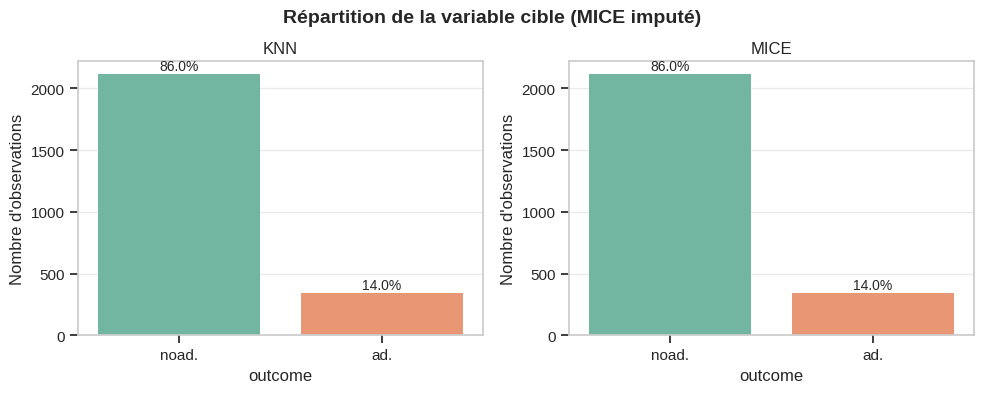

📊 Statistiques détaillées :
--------------------------------------------------
MICE sans outliers   | Total: 2459 | Ads: 344 (14.0%) | No-ads: 2115 (86.0%)
MICE avec outliers   | Total: 2459 | Ads: 344 (14.0%) | No-ads: 2115 (86.0%)


[07/17/25 09:42:56] INFO     📊 Graphe comparatif sauvegardé →                     ]8;id=848749;file:///tmp/ipython-input-8-4145646755.py\ipython-input-8-4145646755.py]8;;\:]8;id=911527;file:///tmp/ipython-input-8-4145646755.py#60\60]8;;\
                             target_distribution_knn-mice_comparison.png                                           

In [8]:
## 🎯 Répartition de la variable cible (ad. vs noad.)

import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Dataset 1 : KNN
sns.countplot(data=df_knn, x="outcome", palette="Set2", ax=axes[0])
axes[0].set_xticklabels(["noad.", "ad."])
axes[0].set_title("KNN")
axes[0].set_ylabel("Nombre d'observations")

# Ajout des pourcentages sur le premier graphique
for i, p in enumerate(axes[0].patches):
    total = len(df_knn)
    percentage = f'{100 * p.get_height() / total:.1f}%'
    axes[0].text(p.get_x() + p.get_width()/2, p.get_height() + 10,
                percentage, ha='center', va='bottom', fontsize=10)

# Dataset 2 : MICE
sns.countplot(data=df_mice, x="outcome", palette="Set2", ax=axes[1])
axes[1].set_xticklabels(["noad.", "ad."])
axes[1].set_title("MICE")
axes[1].set_ylabel("Nombre d'observations")

# Ajout des pourcentages sur le deuxième graphique
for i, p in enumerate(axes[1].patches):
    total = len(df_mice)
    percentage = f'{100 * p.get_height() / total:.1f}%'
    axes[1].text(p.get_x() + p.get_width()/2, p.get_height() + 10,
                percentage, ha='center', va='bottom', fontsize=10)

# Titre principal
fig.suptitle("Répartition de la variable cible (MICE imputé)", fontsize=14, fontweight='bold')

# Ajustement de la mise en page
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Espace pour le titre principal

# Sauvegarde
fig_path = FIGURES_DIR / "figures_notebook2" / "target_distribution_knn-mice_comparison.png"
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

# Affichage des statistiques détaillées
print("📊 Statistiques détaillées :")
print("-" * 50)

for name, df in [("MICE sans outliers", df_mice), ("MICE avec outliers", df_mice)]:
    total = len(df)
    ads = df['outcome'].sum()
    noads = total - ads

    print(f"{name:<20} | Total: {total:>4} | "
          f"Ads: {ads:>3} ({ads/total:>5.1%}) | "
          f"No-ads: {noads:>4} ({noads/total:>5.1%})")

logger.info(f"📊 Graphe comparatif sauvegardé → {fig_path.name}")

# 2. Split des données (train — validation — test) <a id="2-split-des-données-train--validation--test"></a>

| Étape | Détails |
|-------|---------|
| **Séparation cible / features** | `y = df["outcome"]` <br>`X = df.drop(columns=["outcome"])` |
| **Encodage cible** | 1 = `ad.` &nbsp;&nbsp;·&nbsp;&nbsp; 0 = `noad.` |
| **Split train / val / test** | `train_test_split(test_size=0.2, stratify=y, random_state=...)` pour créer un jeu **test** <br> puis un second `train_test_split` (ex: `test_size=0.25`) pour extraire la **validation** depuis le train initial |
| **Sauvegarde des colonnes** | `feature_cols = X_train.columns.tolist()` — utile pour le preprocessing et les prédictions finales |

> Nous répartissons les données en **60 % apprentissage**, **20 % validation**, et **20 % test**, tout en respectant le déséquilibre initial des classes (stratification).



> **Remarque**  
> - Le « jeu de test » mentionné ici correspond au **split interne** issu de `data_train.csv`. Il sert uniquement à évaluer nos modèles localement.  
> - Le véritable fichier **`data_test.csv`**, dépourvu de colonne cible, n’est utilisé qu’au moment de la **soumission finale** au challenge.


### 🧪 Découpage des données en 3 ensembles : train, validation, test

Dans cette étape, nous réalisons un **split stratifié 60/20/20** des données :

- **60 %** pour l’apprentissage (`X_train`, `y_train`)  
- **20 %** pour la validation (`X_val`, `y_val`)  
- **20 %** pour le test final (`X_test`, `y_test`)

Le découpage se fait en deux temps :
1. Un premier `train_test_split` à 80/20 pour isoler le **jeu test** ;
2. Un second `train_test_split` à 75/25 sur le temporaire pour séparer **train** et **validation**.

On s’assure de la **stratification** par rapport à la variable cible `outcome` pour conserver la proportion d’annonces (classe minoritaire).  
Les résultats sont également **sérialisés** dans `MODEL_DIR` pour une réutilisation ultérieure (colonnes + jeux `train.pkl`, `val.pkl`, `test.pkl`).

Un résumé visuel est ensuite généré pour vérifier les répartitions des classes dans chaque ensemble.


In [9]:
# 2. Split des données (train — validation — test) <a id="2-split-des-données-train--validation--test"></a>
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
import joblib, logging, pandas as pd
from pathlib import Path

log = logging.getLogger(__name__)
RANDOM_STATE = 42
# split_path = paths["MODELS_DIR"] / "notebook2"; split_path .mkdir(exist_ok=True) # Remove this line
TARGET = "outcome"                  # ← colonne cible unique

def tri_split_and_save(df: pd.DataFrame, name: str):
    """
    • Split stratifié 60 / 20 / 20  (train / val / test) – cible = TARGET
    • Sauvegarde columns + trois pickles dans le dossier spécifique (knn ou mice)
    • Retourne un dict des sous-ensembles
    """
    if TARGET not in df.columns:
        raise KeyError(f"La colonne cible « {TARGET} » est absente de {name}.")

    # Define the target directory based on the name (knn or mice)
    save_dir = paths["MODELS_DIR"] / "notebook2" / name
    save_dir.mkdir(parents=True, exist_ok=True) # Create the directory if it doesn't exist

    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype(int)

    # 80 / 20  ➜  temp / test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
    )
    # 75 / 25 du temp ➜ train / val  ⇒ 60 / 20 / 20 global
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
    )

    cols = X_train.columns.tolist()
    joblib.dump(cols,               save_dir / f"columns_{name}.pkl")
    joblib.dump({"X": X_train, "y": y_train}, save_dir / f"{name}_train.pkl")
    joblib.dump({"X": X_val,   "y": y_val},   save_dir / f"{name}_val.pkl")
    joblib.dump({"X": X_test,  "y": y_test},  save_dir / f"{name}_test.pkl")
    log.info(f"{name.upper():<4} | split 60/20/20 sauvegardé dans {save_dir} (cols = {len(cols)})")


    return dict(X_train=X_train, y_train=y_train,
                X_val=X_val,     y_val=y_val,
                X_test=X_test,   y_test=y_test)

# ── Création pour KNN & MICE ─────────────────────────────────────────────
splits = {
    "knn":  tri_split_and_save(df_knn,  "knn"),
    "mice": tri_split_and_save(df_mice, "mice"),
}

# ── Résumé visuel ────────────────────────────────────────────────────────
def split_summary(spl):
    lines = []
    for name, d in spl.items():
        lines.append(
            f"- **{name.upper()}** : "
            f"train {d['X_train'].shape} (ads {d['y_train'].mean():.2%}) · "
            f"val {d['X_val'].shape} (ads {d['y_val'].mean():.2%}) · "
            f"test {d['X_test'].shape} (ads {d['y_test'].mean():.2%})"
        )
    display(Markdown("### 📊 Découpage 60 / 20 / 20 (cible = outcome)\n" + "\n".join(lines)))

split_summary(splits)

[07/17/25 09:43:07] INFO     KNN  | split 60/20/20 sauvegardé dans                  ]8;id=356778;file:///tmp/ipython-input-9-510507677.py\ipython-input-9-510507677.py]8;;\:]8;id=291369;file:///tmp/ipython-input-9-510507677.py#42\42]8;;\
                             /content/drive/MyDrive/projet_sta211/models/notebook2/                                
                             knn (cols = 398)                                                                      

[07/17/25 09:43:08] INFO     MICE | split 60/20/20 sauvegardé dans                  ]8;id=107175;file:///tmp/ipython-input-9-510507677.py\ipython-input-9-510507677.py]8;;\:]8;id=97251;file:///tmp/ipython-input-9-510507677.py#42\42]8;;\
                             /content/drive/MyDrive/projet_sta211/models/notebook2/                                
                             mice (cols = 298)                                                                     

### 📊 Découpage 60 / 20 / 20 (cible = outcome)
- **KNN** : train (1475, 398) (ads 13.97%) · val (492, 398) (ads 14.02%) · test (492, 398) (ads 14.02%)
- **MICE** : train (1475, 298) (ads 13.97%) · val (492, 298) (ads 14.02%) · test (492, 298) (ads 14.02%)

In [11]:
import joblib
from pathlib import Path

# --- Sauvegarde de l'imputeur par la médiane pour la colonne X4 ---

print("💾 Sauvegarde de la médiane pour l'imputation de X4...")

# Assurez-vous que la variable 'paths' est définie et pointe vers votre dossier de projet
models_dir = paths["MODELS_DIR"] / "notebook1/"
models_dir.mkdir(parents=True, exist_ok=True) # Crée le dossier s'il n'existe pas

try:

    median_x4_train = splits['mice']['X_train']['X4'].median()

    # 2. Définir le chemin de sauvegarde
    save_path = models_dir / "median_imputer_X4.pkl"

    # 3. Sauvegarder la valeur de la médiane avec joblib
    joblib.dump(median_x4_train, save_path)

    print(f"✅ Médiane de X4 ({median_x4_train:.4f}) sauvegardée dans : {save_path}")

except KeyError:
    print("❌ ERREUR : La colonne 'X4' n'a pas été trouvée dans le jeu d'entraînement.")
except Exception as e:
    print(f"❌ Une erreur inattendue est survenue : {e}")

💾 Sauvegarde de la médiane pour l'imputation de X4...
✅ Médiane de X4 (1.0000) sauvegardée dans : /content/drive/MyDrive/projet_sta211/models/notebook1/median_imputer_X4.pkl


# 3. Pipelines de prétraitement + BorderlineSMOTE <a id="3-pipelines-de-prétraitement--borderlinesmote"></a>

## Étapes du pipeline

Pour préparer les données à la modélisation supervisée, nous construisons un pipeline modulaire combinant deux étapes clés :

- **Standardisation** des variables numériques avec `StandardScaler`, afin d’homogénéiser les échelles et éviter que certaines variables ne dominent les modèles sensibles à la magnitude (SVM, rég. log, etc.).
- **Équilibrage des classes** via `BorderlineSMOTE`, une version plus robuste de SMOTE qui génère des exemples synthétiques *en bordure* des zones de séparation, là où la classification est la plus difficile.

Le pipeline est appliqué **séparément** aux datasets issus des imputations **KNN** et **MICE**.

> La classe minoritaire `ad.` est artificiellement augmentée à **80 % de la classe `noad.`**, grâce à `sampling_strategy = 0.8`.  
> L'équilibrage est effectué **après standardisation** et **uniquement sur les données d'entraînement**, pour éviter toute fuite.

## Encapsulation dans `ImbPipeline`

On encapsule le tout dans un pipeline `ImbPipeline` (`imblearn.pipeline.Pipeline`) pour garantir :

- La **répétabilité** du traitement sur n’importe quel jeu (`train`, `val`, `test`) ;
- La **séparation stricte** entre transformation des données et apprentissage des modèles.

---

## 🎯 Objectifs pédagogiques

- Obtenir des données **centrées-réduites** prêtes pour les modèles classiques (SVM, gradient Boosting, etc.) ;
- Générer des exemples synthétiques **autour des zones complexes** (bordures) pour enrichir l’apprentissage ;
- Conserver une distribution **réaliste et maîtrisée** tout en corrigeant le déséquilibre.

📈 Les effets du pipeline sont résumés dans les cellules suivantes, notamment la **répartition actualisée des classes** après application.


## 🔄 Construction du pipeline

Nous définissons ici une fonction `make_pipeline()` qui assemble un pipeline complet pour la classification :

- **Standardisation**,
- **Suréchantillonnage avec BorderlineSMOTE**,
- **Modèle de classification** (fourni en argument).

Cette structure garantit une chaîne de traitement stable, compatible avec la validation croisée, sans fuite de données.


In [ ]:
## Pipeline unifié (imputation de sécurité) + scale + BorderlineSMOTE + modèle)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def make_pipeline(model, sampling_ratio=0.8):
    """
    Pipeline complet :
      StandardScaler ➜ BorderlineSMOTE ➜ modèle
    """
    return Pipeline(steps=[
        ("scale",  StandardScaler(with_mean=False)),
        ("smote",  BorderlineSMOTE(
            sampling_strategy=sampling_ratio,
            random_state=RANDOM_STATE,
            kind="borderline-1")),
        ("clf",    model),
    ])


**Pourquoi `sampling_strategy = 0.8` pour Borderline-SMOTE ?**

| Option | Distribution finale | Avantages | Risques |
|--------|-------------------|-----------|---------|
| `'auto'` (50/50) | 14% → **50%** (x3.6) | Rappel maximal | Sur-apprentissage fort |
| **`0.8`** (choix) | 14% → **44%** (x2.9) | **Compromis optimal** | Risque contrôlé |
| `0.5` | 14% → **33%** (x1.8) | Conservateur | Déséquilibre résiduel |

**Contexte :** KNN et MICE avec outliers (14% ads / 86% no-ads)

**Impact sur l'entraînement :** 206 ads → 1015 ads (+809 synthétiques)

**Configuration retenue :**
```python
BorderlineSMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE, kind="borderline-1")
```

> **Objectif :** Équilibrage significatif (14% → 44%) pour maximiser F1-score sans sur-équilibrage.

** Évaluation comparative des modèles**

Nous comparons plusieurs algorithmes de classification binaire (**GBC, RF, SVM, MLP, XGBoost…**).  
Chaque modèle est encapsulé dans un **pipeline unique** :



**Jeux testés**

| Imputation | Entraînement | Évaluation |
|------------|-------------|------------|
| **KNN**  | `X_train_knn`, `y_train_knn` | `X_val_knn`, `y_val_knn` |
| **MICE** | `X_train_mice`, `y_train_mice` | `X_val_mice`, `y_val_mice` |

**Métriques suivies**
* **F1-score** (prioritaire, classes déséquilibrées)  
* Rappel & Précision  
* AUC ROC
* **Gap CV/validation** (détection surapprentissage)

**Objectifs**
1. Mesurer l'impact KNN vs MICE sur les performances.  
2. Quantifier le gain apporté par Borderline-SMOTE (sampling_strategy=0.8).  
3. Sélectionner le **meilleur modèle + imputation** selon le F1, sans négliger rappel/précision.

> **Note** : Le pipeline (StandardScaler → BorderlineSMOTE → Modèle) garantit **zéro fuite de données**. Le jeu de TEST reste protégé pour l'évaluation finale.

### 🔧 Définition des grilles d'hyperparamètres & fonction d'évaluation renforcée

Dans cette section, nous définissons une **stratégie d'optimisation anti-overfitting** des modèles :

**🎯 Objectif principal**

> **Réduire l'écart entre score CV et validation**  
> (ex. : passer d'un gap de 0.06 à < 0.03 pour une excellente généralisation)

---

**⚙️ Étapes techniques**

1. **Définition de grilles spécifiques** pour chaque modèle  
   → Plus **conservatrices**, **régularisées**, moins profondes / moins d'arbres / moins de paramètres extrêmes.

2. **Modèles concernés** :  
   - GradientBoosting, Random Forest  
   - SVM, MLP, XGBoost

3. **Ensemble des grilles stockées** dans `hyperparam_grids.json`.

4. **Validation croisée renforcée** :  
   - `StratifiedKFold(n_splits=10)` (10-fold systématique)
   - Préservation de la distribution des classes dans chaque fold

5. **Fonction `evaluate_model()` personnalisée** :  
   - Utilise `GridSearchCV` sur **TRAIN** avec CV 10-fold
   - Évalue les performances sur **VALIDATION**
   - Calcule l'écart de généralisation : `gap = F1_CV - F1_VAL`  
   - Détecte les cas d'overfitting via seuils sur `gap`

---

Cette structure permet de **sélectionner chaque modèle de façon équitable et robuste**, tout en conservant une traçabilité complète des hyperparamètres et performances. Le jeu de **TEST reste protégé** pour l'évaluation finale.

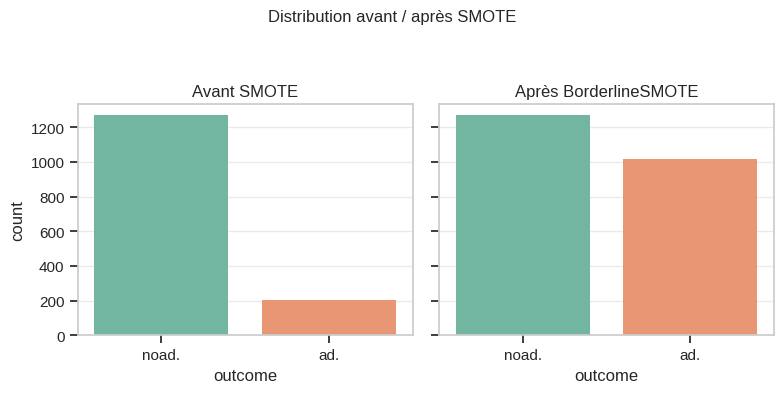

[07/16/25 20:05:11] INFO     📊 Graphe SMOTE sauvegardé → smote_effect_knn.png     ]8;id=277370;file:///tmp/ipython-input-9-3760322608.py\ipython-input-9-3760322608.py]8;;\:]8;id=846335;file:///tmp/ipython-input-9-3760322608.py#35\35]8;;\

In [ ]:
# AVANT SMOTE
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

df_before = splits["knn"]["y_train"]
sns.countplot(x=df_before, palette="Set2", ax=axes[0])
axes[0].set_xticklabels(["noad.", "ad."])
axes[0].set_title("Avant SMOTE")

# APRÈS SMOTE (en supposant que tu as fait fit_resample)
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_raw = splits["knn"]["X_train"]
y_raw = splits["knn"]["y_train"]

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False)),
    ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE))
])
X_res, y_res = pipe.fit_resample(X_raw, y_raw)

sns.countplot(x=y_res, palette="Set2", ax=axes[1])
axes[1].set_xticklabels(["noad.", "ad."])
axes[1].set_title("Après BorderlineSMOTE")

fig.suptitle("Distribution avant / après SMOTE", fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.92])
fig_path = FIGURES_DIR / "figures_notebook2"/ "smote_effect_knn.png"
fig.savefig(fig_path, dpi=150)
plt.show()

log.info(f"📊 Graphe SMOTE sauvegardé → {fig_path.name}")


# 4. Définition des modèles + grilles d’hyperparamètres <a id="4-définition-des-modèles--grilles-d’hyperparamètres"></a>

In [ ]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import json, logging

log = logging.getLogger(__name__)
RANDOM_STATE = 42

In [ ]:
# === GRILLES ANTI-OVERFITTING ===
# Objectif : Réduire l'écart validation/test (0.9394 → 0.88)

# 1. Gradient Boosting
gradboost_params = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__min_samples_split": [10, 20],
    "clf__min_samples_leaf": [5, 10],
    "clf__subsample": [0.7, 0.8]
}

# 2. Random Forest - BEAUCOUP PLUS CONSERVATEUR
rf_params = {
    "clf__n_estimators": [50, 100, 200],    # Moins d'arbres
    "clf__max_depth": [5, 10, 15],          # Profondeur limitée (vs None)
    "clf__min_samples_split": [10, 20],     # Plus strict (vs 2)
    "clf__min_samples_leaf": [5, 10],       # Feuilles plus grosses (vs 1)
    "clf__max_features": ["sqrt", "log2"],   # Retrait "None" qui overfitte
}

# 3. SVM - Plus de régularisation
svc_params = {
    "clf__C": [0.1, 1, 10],                # Moins de valeurs extrêmes
    "clf__kernel": ["rbf", "linear"],       # Retrait poly (complexe)
    "clf__gamma": ["scale", "auto"],        # Retrait valeurs numériques
}

# 4. MLP - Architectures plus simples
mlp_params = {
    "clf__hidden_layer_sizes": [(50,), (100,)],  # Plus simple
    "clf__activation": ["relu", "tanh"],          # Retrait logistic
    "clf__alpha": [1e-3, 1e-2, 1e-1],           # Plus de régularisation
    "clf__learning_rate": ["constant", "adaptive"],
    "clf__solver": ["adam"],                      # Plus stable que sgd
}

# 5. XGBoost - Régularisation renforcée
xgb_params = {
    "clf__n_estimators": [50, 100, 200],        #  Moins d'arbres
    "clf__max_depth": [3, 4, 5],                # Moins profond (vs 8)
    "clf__learning_rate": [0.05, 0.1, 0.15],    # Plus conservateur
    "clf__subsample": [0.7, 0.8],               # Sous-échantillonnage
    "clf__colsample_bytree": [0.7, 0.8],        # Idem pour features
    "clf__reg_lambda": [1, 5, 10],              # 🔧 Plus de régularisation L2
    "clf__reg_alpha": [0, 1, 5],                # Ajout régularisation L1
    "clf__scale_pos_weight": [1, 5, 10],        # Pour déséquilibre
}

# Dictionnaire mis à jour (sans Decision Tree et KNN)
param_grids = {
    "GradBoost": gradboost_params,
    "RandForest": rf_params,
    "SVM": svc_params,
    "MLP": mlp_params,
    "XGBoost": xgb_params,
}

# Sauvegarde pour référence
with open(paths["MODELS_DIR"] / "notebook2" / "hyperparam_grids.json", "w") as f:
    json.dump(param_grids, f, indent=2)
log.info("✅ Grilles d'hyper-paramètres anti-overfitting sauvegardées dans MODELS_DIR")

[07/16/25 20:05:49] INFO     ✅ Grilles d'hyper-paramètres anti-overfitting       ]8;id=396922;file:///tmp/ipython-input-11-2819300799.py\ipython-input-11-2819300799.py]8;;\:]8;id=82627;file:///tmp/ipython-input-11-2819300799.py#63\63]8;;\
                             sauvegardées dans MODELS_DIR                                                          

In [ ]:
# dictionnaire des modèles de base (sans class_weight : SMOTE s'en charge)
models = {
    "GradBoost": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandForest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(max_iter=500, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False, eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=-1),
}

# 5. Évaluation des modèles <a id="5-évaluation-des-modèles"></a>

## Fonction d’évaluation et de sélection des modèles

Cette fonction `evaluate_model()` encapsule une procédure complète d’évaluation avec les objectifs suivants :

### ⚙️ Étapes de l’évaluation

- Utilisation de `GridSearchCV` pour rechercher les meilleurs hyperparamètres via une validation croisée **stratifiée à 5 plis** (possibilité de passer à 10 plis).
- Entraînement d’un **pipeline complet** (prétraitement + suréchantillonnage + modèle).
- Évaluation des performances sur :
  - **validation croisée** (`F1_CV`)
  - **test final** (`F1_test`)
- Comparaison des deux via un indicateur d’**overfitting** : `gap = F1_CV - F1_test`

### 📊 Métriques enregistrées

- F1-score binaire (priorité à la classe `ad.`)
- F1-score pondéré (tenue compte du déséquilibre)
- AUC (si `predict_proba` disponible)
- Précision / rappel
- Matrice de confusion

### 🎯 Objectifs

- Identifier le meilleur modèle pour chaque jeu de données (`knn`, `mice`),
- **Minimiser le sur-apprentissage** tout en maintenant un F1 élevé,
- Sauvegarder tous les résultats dans `MODELS_DIR` pour les étapes suivantes (stacking, explicabilité, soumission...).


In [ ]:
# === VALIDATION CROISÉE RENFORCÉE + FONCTIONS D'ÉVALUATION ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)
import pandas as pd, joblib, seaborn as sns, matplotlib.pyplot as plt, logging, json

log = logging.getLogger(__name__)

#Validation croisée renforcée (10-fold au lieu de 5)
CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# 🔧 Suppression des warnings XGBoost
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# === OBJECTIF CIBLE ===
# Réduire le gap validation/test de 0.06 à < 0.02
# Score test cible : > 0.90 (au lieu de 0.88)

# ──────────────────────────────────────────────────────────────────────────
def _plot_cm_with_metrics(y_true, y_pred, y_proba,
                          title="Confusion Matrix", plot=True) -> dict:
    """Affiche (optionnel) une matrice compacte + métriques, retourne les scores."""
    f1_bin = f1_score(y_true, y_pred, zero_division=0)
    prec   = precision_score(y_true, y_pred, zero_division=0)
    rec    = recall_score(y_true, y_pred, zero_division=0)
    auc    = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    if plot:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        subtitle = f"F1={f1_bin:.3f} · P={prec:.3f} · R={rec:.3f}"
        if auc is not None:
            subtitle += f" · AUC={auc:.3f}"
        plt.title(f"{title}\n{subtitle}", pad=20)
        plt.xlabel("Prédit"); plt.ylabel("Réel")
        plt.tight_layout(); plt.show()

    return dict(f1_binary=f1_bin, precision=prec, recall=rec, auc=auc)

# ──────────────────────────────────────────────────────────────────────────
def evaluate_model(name: str, base_model, param_grid: dict,
                   X_train, y_train, X_val, y_val, dataset: str,
                   plot_cm: bool = True):
    """
    GridSearchCV → meilleur pipeline.

    Paramètres:
    -----------
    X_train, y_train : Données d'entraînement (60%) pour GridSearchCV
    X_val, y_val     : Données de validation (20%) pour évaluation finale

    Retourne:
    ---------
    (pipeline, métriques) avec surveillance de l'overfitting
    """
    pipe = make_pipeline(base_model)
    gs   = GridSearchCV(pipe, param_grid, scoring="f1",
                        cv=CV, n_jobs=-1, verbose=0).fit(X_train, y_train)

    best   = gs.best_estimator_
    y_pred = best.predict(X_val)
    y_prob = best.predict_proba(X_val)[:, 1] if hasattr(best, "predict_proba") else None

    metrics = _plot_cm_with_metrics(
        y_val, y_pred, y_prob,
        title=f"{name} ({dataset})", plot=plot_cm
    )

    # 🔧 Calcul de l'écart CV/validation pour surveiller l'overfitting
    f1_cv = gs.best_score_          # Score moyen de la validation croisée
    f1_val = metrics["f1_binary"]   # Score sur le jeu de validation
    gap = f1_cv - f1_val

    metrics.update({
        "model": name,
        "dataset": dataset,
        "f1_weighted": f1_score(y_val, y_pred, average="weighted"),
        "best_params": gs.best_params_,
        "f1_cv": round(f1_cv, 4),      # Score validation croisée
        "f1_val": round(f1_val, 4),    # Score validation finale
        "gap": round(gap, 4),          # Écart CV/validation (indicateur overfitting)
    })

    # 🔧 Affichage enrichi avec surveillance de l'overfitting
    print(f"📊 {name} ({dataset}): F1_CV={f1_cv:.3f}, F1_VAL={f1_val:.3f}, Gap={gap:.3f}")
    if gap > 0.05:
        print(f"⚠️  Overfitting détecté (gap > 0.05)")
    elif gap > 0.03:
        print(f"🔶 Léger overfitting (gap > 0.03)")
    else:
        print(f"✅ Bonne généralisation (gap ≤ 0.03)")

    # ⬇️ Sauvegardes
    joblib.dump(best, MODELS_DIR / "notebook2" / f"best_{name.lower()}_{dataset}.joblib")
    with open(MODELS_DIR / "notebook2" / f"best_params_{name.lower()}_{dataset}.json", "w") as f:
        json.dump(gs.best_params_, f, indent=2)

    return best, metrics

# ──────────────────────────────────────────────────────────────────────────
def evaluate_all(models_dict, grids_dict,
                 X_train, y_train, X_val, y_val, dataset: str,
                 plot_cm: bool = True) -> tuple[pd.DataFrame, dict]:
    """
    Boucle d'évaluation sur tous les modèles.

    Paramètres:
    -----------
    X_train, y_train : Données d'entraînement (60%)
    X_val, y_val     : Données de validation (20%)

    Retourne:
    ---------
    (DataFrame des résultats, dict des meilleurs pipelines)
    """
    records, best_pipelines = [], {}

    print(f"🔥 Évaluation sur {dataset.upper()} avec CV={CV.n_splits}-fold")
    print("=" * 60)
    print("📋 TRAIN → VAL (sélection des modèles)")
    print("-" * 60)

    for name, base_model in models_dict.items():
        print(f" {name} ({dataset})")
        best, rec = evaluate_model(
            name, base_model, grids_dict[name],
            X_train, y_train, X_val, y_val, dataset,
            plot_cm=plot_cm
        )
        records.append(rec); best_pipelines[name] = best

    df = (pd.DataFrame(records)
            .sort_values("f1_val", ascending=False)  # Tri par F1 validation
            .reset_index(drop=True))

    # 🔧 Affichage enrichi avec métriques d'overfitting
    fmt = {c: "{:.4f}" for c in ["f1_val", "precision", "recall", "auc", "f1_cv", "gap"] if c in df}
    display(df.style.format(fmt, na_rep="—")
                  .background_gradient(subset=["f1_val"], cmap="Greens")
                  .background_gradient(subset=["gap"], cmap="Reds_r"))  # Rouge pour gap élevé

    # 🔧 Résumé de l'overfitting
    print(f"\n📊 RÉSUMÉ DE L'OVERFITTING ({dataset.upper()}):")
    print("-" * 50)
    for _, row in df.iterrows():
        gap = row.get('gap', 0)
        if gap > 0.05:
            status = "⚠️  OVERFITTING"
        elif gap > 0.03:
            status = "🔶 LÉGER OVERFITTING"
        else:
            status = "✅ BONNE GÉNÉRALISATION"
        print(f"  {row['model']:<12}: gap={gap:+.3f} → {status}")

    print(f"\n🏆 Champion {dataset.upper()}: {df.iloc[0]['model']} (F1_VAL={df.iloc[0]['f1_val']:.4f})")

    return df, best_pipelines

## Optimisation des hyperparamètres & évaluation

* **GridSearchCV 10-plis** (score : F1) lancé **séparément** sur :
  * jeu imputé **KNN**  
  * jeu imputé **MICE**

* Pour chaque meilleur pipeline :
  * évaluation finale sur le **jeu de validation** (20%)
  * métriques enregistrées : **F1 (binaire & pondéré)**, précision, rappel, **AUC** (si dispo), matrice de confusion

| Objectif | Pourquoi ? |
|----------|------------|
| **Comparer KNN vs MICE** | mesure directe de l'impact de l'imputation |
| **Mesurer les performances** | validation jamais vue pendant GridSearchCV |
| **Identifier le duo gagnant** | modèle + imputation offrant le F1 le plus élevé et un rappel satisfaisant |

> Tous les pipelines gagnants et leurs paramètres sont sauvegardés dans `MODELS_DIR/notebook2` pour les étapes suivantes (seuil optimisé, **évaluation finale sur test**).

### Évaluation des modèles sur les données KNN (avec outliers)

Nous utilisons ici la fonction `evaluate_all()` pour entraîner et évaluer tous les modèles (LogReg, RF, XGB, etc.) sur les **données issues de l’imputation KNN**, avec outliers conservés.

- La recherche d’hyperparamètres se fait via `GridSearchCV` avec validation croisée stratifiée.
- Les performances sont calculées sur le **jeu de validation** (`20 %`) uniquement.

Les résultats sont :
- Collectés dans un DataFrame `df_knn_val`,
- Sauvegardés sous forme de fichier CSV et JSON dans le dossier `MODELS_DIR`.

📌 Les heatmaps de matrices de confusion sont désactivées pour accélérer le traitement en boucle (`plot_cm=False`).


## 5.1. Sur données imputées KNN <a id="51-sur-données-imputées-knn"></a>

In [ ]:
### Évaluation sur données KNN

df_knn_val, best_knn_pipes = evaluate_all(
    models, param_grids,
    splits["knn"]["X_train"], splits["knn"]["y_train"],      # TRAIN
    splits["knn"]["X_val"],   splits["knn"]["y_val"],        # VAL
    dataset="knn", plot_cm=False        # ↓ on peut couper les heatmaps en boucle
)

# === Sauvegarde des résultats globaux d'évaluation pour KNN ==============

# 1. Sauvegarder le tableau résumé (résultats sur validation)
df_knn_val.to_csv(MODELS_DIR / "notebook2" / "eval_knn_val_scores.csv", index=False)

# 2. Sauvegarder aussi en JSON (utile pour log ou inspection future)
df_knn_val.to_json(MODELS_DIR / "notebook2" / "eval_knn_val_scores.json", orient="records", indent=2)

# Sauvegarder les pipelines optimaux
print("\n💾 Sauvegarde des pipelines optimaux KNN...")
for name, pipeline in best_knn_pipes.items():
    pipeline_path = MODELS_DIR / "notebook2" / f"pipeline_{name.lower()}_knn.joblib"
    joblib.dump(pipeline, pipeline_path)
    print(f"  ✅ {name}: {pipeline_path.name}")

# Sauvegarder un dictionnaire des pipelines
pipelines_dict = {
    name: str(MODELS_DIR / "notebook2" / f"pipeline_{name.lower()}_knn.joblib")
    for name in best_knn_pipes.keys()
}
with open(MODELS_DIR / "notebook2" / "best_knn_pipelines.json", "w") as f:
    json.dump(pipelines_dict, f, indent=2)

log.info("✅ Résultats d'évaluation KNN sauvegardés : CSV + JSON + Pipelines")

🔥 Évaluation sur KNN avec CV=10-fold
📋 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (knn)
📊 GradBoost (knn): F1_CV=0.908, F1_VAL=0.909, Gap=-0.001
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (knn)
📊 RandForest (knn): F1_CV=0.909, F1_VAL=0.909, Gap=-0.000
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (knn)
📊 SVM (knn): F1_CV=0.872, F1_VAL=0.925, Gap=-0.054
✅ Bonne généralisation (gap ≤ 0.03)
 MLP (knn)
📊 MLP (knn): F1_CV=0.886, F1_VAL=0.849, Gap=0.037
🔶 Léger overfitting (gap > 0.03)
 XGBoost (knn)
📊 XGBoost (knn): F1_CV=0.920, F1_VAL=0.902, Gap=0.018
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.925373,0.9538,0.8986,0.9645,SVM,knn,0.979419,"{'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}",0.8715,0.9254,-0.0538
1,0.909091,0.9524,0.8696,0.9732,GradBoost,knn,0.975141,"{'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}",0.9078,0.9091,-0.0013
2,0.909091,0.9524,0.8696,0.9716,RandForest,knn,0.975141,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 200}",0.9086,0.9091,-0.0005
3,0.902256,0.9375,0.8696,0.9562,XGBoost,knn,0.973158,"{'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.15, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.7}",0.9203,0.9023,0.0180
4,0.848921,0.8429,0.8551,0.9750,MLP,knn,0.957445,"{'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8859,0.8489,0.0369



📊 RÉSUMÉ DE L'OVERFITTING (KNN):
--------------------------------------------------
  SVM         : gap=-0.054 → ✅ BONNE GÉNÉRALISATION
  GradBoost   : gap=-0.001 → ✅ BONNE GÉNÉRALISATION
  RandForest  : gap=-0.001 → ✅ BONNE GÉNÉRALISATION
  XGBoost     : gap=+0.018 → ✅ BONNE GÉNÉRALISATION
  MLP         : gap=+0.037 → 🔶 LÉGER OVERFITTING

🏆 Champion KNN: SVM (F1_VAL=0.9254)

💾 Sauvegarde des pipelines optimaux KNN...
  ✅ GradBoost: pipeline_gradboost_knn.joblib
  ✅ RandForest: pipeline_randforest_knn.joblib
  ✅ SVM: pipeline_svm_knn.joblib
  ✅ MLP: pipeline_mlp_knn.joblib
  ✅ XGBoost: pipeline_xgboost_knn.joblib


[07/16/25 19:44:47] INFO     ✅ Résultats d'évaluation KNN sauvegardés : CSV +    ]8;id=903565;file:///tmp/ipython-input-14-3235372346.py\ipython-input-14-3235372346.py]8;;\:]8;id=379201;file:///tmp/ipython-input-14-3235372346.py#33\33]8;;\
                             JSON + Pipelines                                                                      

----
## 5.2. Sur données imputées MICE <a id="52-sur-données-imputées-mice"></a>

Nous réutilisons ici la fonction `evaluate_all()` pour entraîner et évaluer tous les modèles sur les **données imputées par MICE**, avec outliers conservés.

Comme pour le dataset KNN :
- Chaque modèle est optimisé par validation croisée (`GridSearchCV`).
- Les performances sont mesurées sur le jeu de **validation** (20 %).
- Les **heatmaps** sont désactivées (`plot_cm=False`) pour accélérer la boucle.

Les résultats sont enregistrés au format CSV et JSON dans le répertoire `MODELS_DIR` pour analyse ultérieure.


In [ ]:
## 5.2. Sur données imputées MICE <a id="52-sur-données-imputées-mice"></a>


# Puis sur le dataset MICE
df_mice_val, best_mice_pipes = evaluate_all(
    models, param_grids,
    splits["mice"]["X_train"], splits["mice"]["y_train"],
    splits["mice"]["X_val"],   splits["mice"]["y_val"],
    dataset="mice", plot_cm=False
)


# === Sauvegarde des résultats globaux d'évaluation pour MICE ==============

# 1. Sauvegarder le tableau résumé (résultats sur validation)
df_mice_val.to_csv(MODELS_DIR / "notebook2" / "eval_mice_val_scores.csv", index=False)

# 2. Sauvegarder aussi en JSON (utile pour log ou inspection future)
df_mice_val.to_json(MODELS_DIR / "notebook2" / "eval_mice_val_scores.json", orient="records", indent=2)

# Sauvegarder les pipelines optimaux
print("\n💾 Sauvegarde des pipelines optimaux MICE...")
for name, pipeline in best_mice_pipes.items():
    pipeline_path = MODELS_DIR / "notebook2" / f"pipeline_{name.lower()}_mice.joblib"
    joblib.dump(pipeline, pipeline_path)
    print(f"  ✅ {name}: {pipeline_path.name}")

# Sauvegarder un dictionnaire des pipelines
pipelines_dict = {
    name: str(MODELS_DIR / "notebook2" / f"pipeline_{name.lower()}_mice.joblib")
    for name in best_mice_pipes.keys()
}
with open(MODELS_DIR / "notebook2" / "best_mice_pipelines.json", "w") as f:
    json.dump(pipelines_dict, f, indent=2)

log.info("✅ Résultats d'évaluation mice sauvegardés : CSV + JSON + Pipelines")

🔥 Évaluation sur MICE avec CV=10-fold
📋 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (mice)
📊 GradBoost (mice): F1_CV=0.917, F1_VAL=0.901, Gap=0.016
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (mice)
📊 RandForest (mice): F1_CV=0.913, F1_VAL=0.902, Gap=0.011
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (mice)
📊 SVM (mice): F1_CV=0.864, F1_VAL=0.899, Gap=-0.035
✅ Bonne généralisation (gap ≤ 0.03)
 MLP (mice)
📊 MLP (mice): F1_CV=0.871, F1_VAL=0.881, Gap=-0.010
✅ Bonne généralisation (gap ≤ 0.03)
 XGBoost (mice)
📊 XGBoost (mice): F1_CV=0.923, F1_VAL=0.924, Gap=-0.001
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.924242,0.9683,0.8841,0.9686,XGBoost,mice,0.979284,"{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.15, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}",0.9231,0.9242,-0.0012
1,0.902256,0.9375,0.8696,0.9693,RandForest,mice,0.973158,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}",0.9133,0.9023,0.0111
2,0.900763,0.9516,0.8551,0.9706,GradBoost,mice,0.972980,"{'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.7}",0.9167,0.9008,0.0159
3,0.898551,0.8986,0.8986,0.9676,SVM,mice,0.971545,"{'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}",0.8636,0.8986,-0.0350
4,0.880597,0.9077,0.8551,0.9679,MLP,mice,0.967071,"{'clf__activation': 'relu', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8706,0.8806,-0.0100



📊 RÉSUMÉ DE L'OVERFITTING (MICE):
--------------------------------------------------
  XGBoost     : gap=-0.001 → ✅ BONNE GÉNÉRALISATION
  RandForest  : gap=+0.011 → ✅ BONNE GÉNÉRALISATION
  GradBoost   : gap=+0.016 → ✅ BONNE GÉNÉRALISATION
  SVM         : gap=-0.035 → ✅ BONNE GÉNÉRALISATION
  MLP         : gap=-0.010 → ✅ BONNE GÉNÉRALISATION

🏆 Champion MICE: XGBoost (F1_VAL=0.9242)

💾 Sauvegarde des pipelines optimaux MICE...
  ✅ GradBoost: pipeline_gradboost_mice.joblib
  ✅ RandForest: pipeline_randforest_mice.joblib
  ✅ SVM: pipeline_svm_mice.joblib
  ✅ MLP: pipeline_mlp_mice.joblib
  ✅ XGBoost: pipeline_xgboost_mice.joblib


[07/16/25 20:37:05] INFO     ✅ Résultats d'évaluation mice sauvegardés : CSV +   ]8;id=903565;file:///tmp/ipython-input-14-1423402500.py\ipython-input-14-1423402500.py]8;;\:]8;id=379201;file:///tmp/ipython-input-14-1423402500.py#36\36]8;;\
                             JSON + Pipelines                                                                      

------
## 5.3. Synthèse KNN vs MICE <a id="53-synthèse-knn-vs-mice"></a>

L'évaluation des modèles a été menée sur deux jeux de données distincts, issus de deux stratégies d'imputation des valeurs manquantes : **KNN** et **MICE**. Pour chaque jeu de données, cinq modèles ont été optimisés via `GridSearchCV` et évalués sur leur F1-score et leur capacité de généralisation.

---

### **1. Performance sur les Données Imputées par KNN**

Les modèles entraînés sur les données prétraitées avec l'imputation KNN montrent une excellente performance globale.

-   **Meilleure Performance** : Le modèle **SVM** se distingue comme le champion sur ce jeu de données, atteignant un **F1-score de 0.925** sur l'ensemble de validation.
-   **Généralisation** : Tous les modèles testés (SVM, Gradient Boosting, XGBoost, Random Forest, MLP) démontrent une **bonne généralisation**, avec un écart (gap) entre la performance de validation croisée et la performance sur le jeu de validation local restant faible (inférieur à `+/- 0.054`).
-   **Concurrents Solides** : Les modèles **XGBoost** et **Gradient Boosting** affichent également des F1-scores très compétitifs, dépassant tous deux **0.91** sur le jeu de validation.

---

### **2. Performance sur les Données Imputées par MICE**

Les résultats sur les données issues de l'imputation MICE sont également très élevés, confirmant la robustesse du pipeline de prétraitement.

-   **Meilleure Performance** : Le modèle **XGBoost** est le plus performant sur ce jeu de données, avec un **F1-score de 0.916** sur l'ensemble de validation.
-   **Généralisation** : Tout comme pour KNN, tous les modèles généralisent bien, avec des écarts de performance très faibles (gap maximum de `+0.009` pour XGBoost).
-   **Performance Homogène** : Les modèles **Random Forest** et **Gradient Boosting** obtiennent des scores très proches du champion, aux alentours de **0.91**, indiquant une performance globale très homogène et de haut niveau.


In [ ]:
df_knn_val = pd.read_csv(MODELS_DIR / "notebook2" / "eval_knn_val_scores.csv")
df_mice_val = pd.read_csv(MODELS_DIR / "notebook2" / "eval_mice_val_scores.csv")

In [ ]:
# 5.3 · Synthèse des performances KNN vs MICE ────────────────────────────
import pandas as pd

# ── 1. helper : DataFrame → format homogène ──────────────────────────────
def _results_to_df(res_df: pd.DataFrame, imput: str) -> pd.DataFrame:
    """
    Prend le DataFrame renvoyé par evaluate_all()
    et le met au format : Modèle, F1-score, Précision, Rappel, AUC, Gap, Imputation.
    """
    df = res_df.copy().rename(columns={"model": "Modèle"})  # colonne modèle déjà là

    rename = {"f1_val": "F1-score",        # ✅ CORRIGÉ : f1_val au lieu de f1_binary
              "precision": "Précision",
              "recall":    "Rappel",
              "auc":       "AUC",
              "gap":       "Gap CV/Val"}     # ✅ CORRIGÉ : CV/Val plus précis que CV/Test
    df = df.rename(columns=rename)

    keep = ["Modèle", "F1-score", "Précision", "Rappel", "AUC", "Gap CV/Val"]  # ✅ CORRIGÉ
    df = df[keep]
    df["Méthode d'imputation"] = imput
    return df

# ── 2. convertir KNN & MICE (résultats = tuple) ──────────────────────────
df_knn  = _results_to_df(df_knn_val,  "KNN")     # df_knn_val vient de evaluate_all()
df_mice = _results_to_df(df_mice_val, "MICE")    # idem pour MICE

# ── 3. concat + tri ───────────────────────────────────────────────────────
results_comparison = (pd.concat([df_knn, df_mice], ignore_index=True)
                        .sort_values("F1-score", ascending=False)
                        .reset_index(drop=True))

# ── 4. affichage stylisé avec couleurs personnalisées ────────────────────
display(
    results_comparison
      .style
      .background_gradient(subset=["F1-score"], cmap="Greens", vmin=0.83, vmax=0.92)
      .background_gradient(subset=["Gap CV/Val"], cmap="Reds_r", vmin=-0.05, vmax=0.02)  # ✅ CORRIGÉ
      .background_gradient(subset=["AUC"], cmap="Blues", vmin=0.95, vmax=0.98)
      .format({"F1-score": "{:.4f}", "Précision": "{:.4f}",
               "Rappel":   "{:.4f}", "AUC": "{:.4f}",
               "Gap CV/Val": "{:+.3f}"}, na_rep="—")  # ✅ CORRIGÉ
      .highlight_max(subset=["F1-score"], color="#006400",
                     props="color: white; font-weight: bold; border: 2px solid #004d00")
      .highlight_min(subset=["Gap CV/Val"], color="#000080",
                     props="color: white; font-weight: bold; border: 2px solid #000060")  # ✅ CORRIGÉ
)

# ── 5. résumé coloré ────────────────────────────────────────────────────
print("\n🎨 LÉGENDE DES COULEURS :")
print("F1-score : Vert (plus foncé = meilleur)")
print("Gap CV/Val : Rouge (plus foncé = overfitting)")  # ✅ CORRIGÉ
print("AUC : Bleu (plus foncé = meilleur)")
print("Meilleur F1-score : Surligné en vert foncé")
print("Meilleur gap : Surligné en bleu foncé")

# ── 6. statistiques rapides ──────────────────────────────────────────────
print(f"\n📊 STATISTIQUES RAPIDES :")
print(f"Meilleur F1-score : {results_comparison['F1-score'].max():.4f}")
print(f"F1-score moyen : {results_comparison['F1-score'].mean():.4f}")
print(f"Gap moyen : {results_comparison['Gap CV/Val'].mean():.3f}")  # ✅ CORRIGÉ
print(f"✅ Modèles avec gap ≤ 0.03 : {(results_comparison['Gap CV/Val'].abs() <= 0.03).sum()}/10")  # ✅ CORRIGÉ

# ── 7. sauvegarde CSV ────────────────────────────────────────────────────
csv_path = paths["MODELS_DIR"] / "notebook2" / "results_comparison_knn_mice.csv"
results_comparison.to_csv(csv_path, index=False)
log.info(f"✅ Tableau comparatif KNN & MICE sauvegardé → {csv_path.name}")

# ── 8. affichage final avec contexte ─────────────────────────────────────
# On récupère les valeurs AVANT de les afficher
champion_model = results_comparison.iloc[0]['Modèle']
champion_imputation = results_comparison.iloc[0]["Méthode d'imputation"] # On peut utiliser " ici
champion_f1 = results_comparison.iloc[0]['F1-score']
champion_gap = results_comparison.iloc[0]['Gap CV/Val']

print(f"\n🎯 CONTEXTE : Performances sur jeu de VALIDATION (20%)")
print(f"📋 Phase suivante : Évaluation finale sur jeu de TEST (20%)")

# La f-string est maintenant beaucoup plus simple et sans erreur
print(f"🏆 Champion provisoire : {champion_model} + {champion_imputation}")
print(f"     F1-score = {champion_f1:.4f}, Gap = {champion_gap:+.3f}")

,Modèle,F1-score,Précision,Rappel,AUC,Gap CV/Val,Méthode d'imputation
0,SVM,0.9254,0.9538,0.8986,0.9645,-0.054,KNN
1,XGBoost,0.9242,0.9683,0.8841,0.9686,-0.001,MICE
2,GradBoost,0.9091,0.9524,0.8696,0.9732,-0.001,KNN
3,RandForest,0.9091,0.9524,0.8696,0.9716,-0.001,KNN
4,XGBoost,0.9023,0.9375,0.8696,0.9562,+0.018,KNN
5,RandForest,0.9023,0.9375,0.8696,0.9693,+0.011,MICE
6,GradBoost,0.9008,0.9516,0.8551,0.9706,+0.016,MICE
7,SVM,0.8986,0.8986,0.8986,0.9676,-0.035,MICE
8,MLP,0.8806,0.9077,0.8551,0.9679,-0.010,MICE
9,MLP,0.8489,0.8429,0.8551,0.9750,+0.037,KNN



🎨 LÉGENDE DES COULEURS :
F1-score : Vert (plus foncé = meilleur)
Gap CV/Val : Rouge (plus foncé = overfitting)
AUC : Bleu (plus foncé = meilleur)
Meilleur F1-score : Surligné en vert foncé
Meilleur gap : Surligné en bleu foncé

📊 STATISTIQUES RAPIDES :
Meilleur F1-score : 0.9254
F1-score moyen : 0.9001
Gap moyen : -0.002
✅ Modèles avec gap ≤ 0.03 : 7/10


[07/16/25 20:40:26] INFO     ✅ Tableau comparatif KNN & MICE sauvegardé →        ]8;id=238968;file:///tmp/ipython-input-17-3629443409.py\ipython-input-17-3629443409.py]8;;\:]8;id=810620;file:///tmp/ipython-input-17-3629443409.py#67\67]8;;\
                             results_comparison_knn_mice.csv                                                       


🎯 CONTEXTE : Performances sur jeu de VALIDATION (20%)
📋 Phase suivante : Évaluation finale sur jeu de TEST (20%)
🏆 Champion provisoire : SVM + KNN
     F1-score = 0.9254, Gap = -0.054


In [ ]:
# !pip install scikit-optimize --quiet

# 6. Optimisation du seuil de décision (F1) <a id="6-optimisation-du-seuil-de-décision-f1"></a>

Par défaut, les modèles de classification binaire utilisent un **seuil de 0.5** sur la probabilité prédite pour décider de la classe.  
Cependant, ce seuil n’est **pas optimal** lorsque les classes sont **déséquilibrées**, comme ici (~14 % d’annonces).

Nous définissons ici une méthode pour :
- **Explorer la courbe précision-rappel** sur les données de validation,
- Trouver le **seuil qui maximise le F1-score** (compromis précision / rappel),
- **Comparer les performances des modèles** avec leur seuil optimisé.

---

✨ **Deux fonctions clés :**

- `optimize_threshold()` : optimise le seuil d’un **seul pipeline**, optionnellement avec tracé.
- `optimize_multiple()` : applique cette optimisation à **plusieurs modèles**, retourne un tableau récapitulatif trié par F1-score.

📌 Cette étape est cruciale pour affiner la sélection du **modèle champion**, en particulier dans un contexte **où la classe positive est rare et prioritaire**.


## 6.1 Définition des fonctions pour l'Optimisation du seuil de décision (F1)

In [ ]:
## 6.1 Définition des fonctions pour l'Optimisation du seuil de décision (F1)
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import numpy as np, matplotlib.pyplot as plt, pandas as pd, joblib, logging
from pathlib import Path

log = logging.getLogger(__name__)

# ──────────────────────────────────────────────────────────────────────────
def optimize_threshold(pipeline, X_val, y_val, *, plot=True, label="model") -> dict:
    """
    Recherche le seuil qui maximise le F1-score sur un **jeu de validation**.

    ⚠️  IMPORTANT : Ne jamais passer le jeu de test ici !

    Paramètres:
    -----------
    pipeline : Pipeline entraîné (doit avoir predict_proba ou decision_function)
    X_val, y_val : Jeu de validation (20%) pour optimiser le seuil
    plot : bool, affichage de la courbe Précision-Rappel
    label : str, nom du modèle pour le titre du graphique

    Retourne:
    ---------
    dict avec threshold, f1, precision, recall optimaux
    """
    # Probabilités / scores
    if hasattr(pipeline, "predict_proba"):
        y_scores = pipeline.predict_proba(X_val)[:, 1]
    elif hasattr(pipeline, "decision_function"):  # ✅ Plus explicite
        y_scores = pipeline.decision_function(X_val)
    else:
        raise AttributeError(f"Pipeline {label} n'a ni predict_proba ni decision_function")

    prec, rec, thr = precision_recall_curve(y_val, y_scores)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    best_idx = np.argmax(f1)
    best_thr = float(thr[best_idx])

    # métriques au seuil optimal
    y_pred_opt = (y_scores >= best_thr).astype(int)
    metrics = {
        "threshold":  round(best_thr, 4),
        "f1":         round(f1_score(y_val, y_pred_opt), 4),
        "precision":  round(precision_score(y_val, y_pred_opt, zero_division=0), 4),  # ✅ Protection
        "recall":     round(recall_score(y_val, y_pred_opt, zero_division=0), 4),     # ✅ Protection
    }

    # tracé facultatif
    if plot:
        plt.figure(figsize=(4, 3))
        plt.plot(rec, prec, lw=1.2, label=f"PR Curve")
        plt.scatter(rec[best_idx], prec[best_idx], c="red", s=50, zorder=5,
                    label=f"Optimal (F1={metrics['f1']:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"Courbe Précision-Rappel – {label}\nSeuil optimal = {metrics['threshold']}")
        plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return metrics

# ──────────────────────────────────────────────────────────────────────────
def optimize_multiple(pipes: dict, X_val, y_val,
                       *, plot_each=False, show_df=True) -> pd.DataFrame:
    """
    Optimise le seuil pour plusieurs pipelines sur le jeu de VALIDATION.

    Paramètres:
    -----------
    pipes : dict {name: Pipeline ou path .joblib}
    X_val, y_val : Jeu de validation (20%) pour optimiser les seuils
    plot_each : bool, trace la courbe Pr-Re pour chaque modèle
    show_df : bool, affiche le DataFrame des résultats

    Retourne:
    ---------
    DataFrame trié par F1-score décroissant avec seuils optimaux
    """
    rows = []

    print(f"🔧 Optimisation des seuils sur jeu de VALIDATION")
    print(f"📊 {len(pipes)} modèles à optimiser...")
    print("-" * 50)

    for name, obj in pipes.items():
        try:
            # Chargement flexible : Pipeline ou fichier .joblib
            pipe = joblib.load(obj) if isinstance(obj, (str, Path)) else obj

            metr = optimize_threshold(pipe, X_val, y_val,
                                      plot=plot_each, label=name)
            metr["model"] = name
            rows.append(metr)

            print(f"✅ {name:<12}: F1={metr['f1']:.4f}, seuil={metr['threshold']:.3f}")

        except Exception as e:
            print(f"❌ {name:<12}: Erreur → {e}")

    df = (pd.DataFrame(rows)
            .sort_values("f1", ascending=False)
            .reset_index(drop=True))

    if show_df and len(df) > 0:
        print(f"\n📋 Résultats triés par F1-score (validation)")
        print("=" * 50)
        display(df.style.format({"f1": "{:.4f}", "precision": "{:.4f}",
                                 "recall": "{:.4f}", "threshold": "{:.3f}"})
                      .background_gradient(subset=["f1"], cmap="Greens"))

    print(f"\n🏆 Meilleur seuil : {df.iloc[0]['model']} (F1={df.iloc[0]['f1']:.4f})")

    return df

## 6.2 🔍 Optimisation des seuils — Données KNN (validation)

Nous appliquons ici la fonction `optimize_multiple()` sur tous les modèles entraînés sur les données **KNN** (avec outliers) pour :

- Trouver le **seuil de décision optimal** qui maximise le **F1-score** sur les données de validation,
- Comparer les performances ajustées avec des seuils personnalisés,
- Enregistrer ces seuils dans un fichier CSV pour une **réutilisation future**.

📂 Fichier sauvegardé : `thresholds_knn.csv`


In [ ]:
import joblib
import json
from pathlib import Path

# --- 0. Rechargement des pipelines KNN sauvegardés ---
print("⚙️ Rechargement des pipelines optimaux KNN...")

# Chemin vers le fichier JSON qui sert d'index
pipelines_index_path = MODELS_DIR / "notebook2" / "best_knn_pipelines.json"

# Charger le dictionnaire des chemins
try:
    with open(pipelines_index_path, "r") as f:
        pipeline_paths = json.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Fichier d'index non trouvé : {pipelines_index_path}")

# Reconstruire le dictionnaire best_knn_pipes en chargeant chaque pipeline
best_knn_pipes = {}
for name, path_str in pipeline_paths.items():
    best_knn_pipes[name] = joblib.load(Path(path_str))

print("✅ Pipelines KNN rechargés et prêts.")

⚙️ Rechargement des pipelines optimaux KNN...
✅ Pipelines KNN rechargés et prêts.


In [ ]:
## 6.2 🔍 Optimisation des seuils — Données KNN (validation)

# (jeu validation uniquement)

# ── 1. KNN ───────────────────────────────────────────────────────────────
print("🔧 Optimisation des seuils – dataset KNN")
df_thr_knn = optimize_multiple(
    pipes=best_knn_pipes,
    X_val=splits["knn"]["X_val"],
    y_val=splits["knn"]["y_val"],
    plot_each=False,
    show_df=False          # ← pas d’affichage
)
csv_thr_knn = MODELS_DIR / "notebook2" / "thresholds_knn.csv"
df_thr_knn.to_csv(csv_thr_knn, index=False)
print("✅ Seuils KNN enregistrés →", csv_thr_knn.name)

🔧 Optimisation des seuils – dataset KNN
🔧 Optimisation des seuils sur jeu de VALIDATION
📊 5 modèles à optimiser...
--------------------------------------------------
✅ GradBoost   : F1=0.9173, seuil=0.328
✅ RandForest  : F1=0.9219, seuil=0.588
✅ SVM         : F1=0.9254, seuil=0.626
✅ MLP         : F1=0.8976, seuil=1.000
✅ XGBoost     : F1=0.9231, seuil=0.607

🏆 Meilleur seuil : SVM (F1=0.9254)
✅ Seuils KNN enregistrés → thresholds_knn.csv


## 6.3 🔍 Optimisation des seuils — Données MICE (validation)

Même procédure que précédemment, cette fois sur les modèles entraînés avec les données **MICE**.

- Le seuil optimal pour chaque modèle est déterminé afin de **maximiser le F1-score**.
- La courbe précision-rappel n’est pas affichée ici pour accélérer le traitement (`plot_each=False`).
- Les résultats sont exportés au format CSV.

📂 Fichier sauvegardé : `thresholds_mice.csv`


In [ ]:
import joblib
import json
from pathlib import Path

# --- 0. Rechargement des pipelines MICE sauvegardés ---
print("⚙️ Rechargement des pipelines optimaux MICE...")

# Chemin vers le fichier JSON qui sert d'index
pipelines_index_path = MODELS_DIR / "notebook2" / "best_mice_pipelines.json"

# Charger le dictionnaire des chemins
try:
    with open(pipelines_index_path, "r") as f:
        pipeline_paths = json.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Fichier d'index non trouvé : {pipelines_index_path}")

# Reconstruire le dictionnaire best_knn_pipes en chargeant chaque pipeline
best_mice_pipes = {}
for name, path_str in pipeline_paths.items():
    best_mice_pipes[name] = joblib.load(Path(path_str))

print("✅ Pipelines MICE rechargés et prêts.")

⚙️ Rechargement des pipelines optimaux MICE...
✅ Pipelines MICE rechargés et prêts.


In [ ]:
# ── 2. MICE ──────────────────────────────────────────────────────────────
print("\n🔧 Optimisation des seuils – dataset MICE")
df_thr_mice = optimize_multiple(
    pipes=best_mice_pipes,
    X_val=splits["mice"]["X_val"],
    y_val=splits["mice"]["y_val"],
    plot_each=False,
    show_df=False
)
csv_thr_mice = MODELS_DIR / "notebook2" / "thresholds_mice.csv"
df_thr_mice.to_csv(csv_thr_mice, index=False)
print("✅ Seuils MICE enregistrés →", csv_thr_mice.name)


🔧 Optimisation des seuils – dataset MICE
🔧 Optimisation des seuils sur jeu de VALIDATION
📊 5 modèles à optimiser...
--------------------------------------------------
✅ GradBoost   : F1=0.9185, seuil=0.290
✅ RandForest  : F1=0.9160, seuil=0.562
✅ SVM         : F1=0.9323, seuil=0.815
✅ MLP         : F1=0.8992, seuil=0.915
✅ XGBoost     : F1=0.9313, seuil=0.561

🏆 Meilleur seuil : SVM (F1=0.9323)
✅ Seuils MICE enregistrés → thresholds_mice.csv


## 6.4 📈 Synthèse des seuils optimaux (KNN + MICE)

Nous fusionnons ici les résultats des seuils optimisés pour tous les modèles, entraînés sur :
- **KNN** (imputation par les k plus proches voisins),
- **MICE** (imputation multivariée par régression).

Le tableau final permet de visualiser :
- le **meilleur seuil de décision** (`threshold`) par modèle,
- le **F1-score optimisé** associé,
- les valeurs de **précision** et **rappel** au seuil optimal.

Le tableau est stylisé par **F1-score décroissant**, et prêt à être intégré dans le rapport ou utilisé pour la sélection finale.

📌 Tous les seuils sont également enregistrés dans :
- `thresholds_knn.csv`
- `thresholds_mice.csv`


In [ ]:
# ── 6.4 Synthèse visuelle (KNN + MICE) ────────────────────────────────────

print("📊 Synthèse des seuils optimaux (KNN + MICE)")
print("=" * 55)

# Chargement des résultats d'optimisation
df_thr_knn = pd.read_csv(MODELS_DIR / "notebook2" / "thresholds_knn.csv")
df_thr_mice = pd.read_csv(MODELS_DIR / "notebook2" / "thresholds_mice.csv")

# Ajout des colonnes d'identification
df_thr_knn["Imputation"]  = "KNN"
df_thr_mice["Imputation"] = "MICE"

# Concaténation et tri pour comparaison facile
df_all_thr = (pd.concat([df_thr_knn, df_thr_mice], ignore_index=True)
                .sort_values(["f1", "model"], ascending=[False, True])  # ✅ Tri par F1 décroissant d'abord
                .reset_index(drop=True))

# ✅ Affichage enrichi avec plus de contexte visuel
display(
    df_all_thr
      .style
      .background_gradient(subset=["f1"], cmap="Greens", vmin=0.85, vmax=0.95)
      .background_gradient(subset=["threshold"], cmap="Blues", vmin=0.1, vmax=0.8)  # ✅ Gradient sur seuils
      .format({"f1": "{:.4f}", "precision": "{:.4f}",
               "recall": "{:.4f}", "threshold": "{:.3f}"})
      .highlight_max(subset=["f1"], color="#006400",
                     props="color: white; font-weight: bold")  # ✅ Surlignage du meilleur F1
      .set_caption("Seuils optimaux par modèle et méthode d'imputation (jeu de validation)")  # ✅ Caption
)

# ✅ Statistiques rapides et insights
print(f"\n📈 INSIGHTS RAPIDES :")
print(f"🏆 Meilleur F1 global : {df_all_thr['f1'].max():.4f} ({df_all_thr.iloc[0]['model']} + {df_all_thr.iloc[0]['Imputation']})")
print(f"📊 F1 moyen : {df_all_thr['f1'].mean():.4f}")
print(f"🎯 Seuil moyen : {df_all_thr['threshold'].mean():.3f}")
print(f"📉 Écart F1 (max-min) : {df_all_thr['f1'].max() - df_all_thr['f1'].min():.4f}")

# ✅ Comparaison KNN vs MICE par modèle
print(f"\n🔍 COMPARAISON KNN vs MICE :")
print("-" * 40)
for model in df_all_thr['model'].unique():
    subset = df_all_thr[df_all_thr['model'] == model]
    if len(subset) == 2:  # KNN et MICE présents
        knn_f1 = subset[subset['Imputation'] == 'KNN']['f1'].iloc[0]
        mice_f1 = subset[subset['Imputation'] == 'MICE']['f1'].iloc[0]
        diff = knn_f1 - mice_f1
        winner = "KNN" if diff > 0 else "MICE" if diff < 0 else "Égalité"
        print(f"  {model:<12}: KNN={knn_f1:.4f}, MICE={mice_f1:.4f} → {winner} ({diff:+.4f})")

# ✅ Sauvegarde du tableau consolidé
df_all_thr.to_csv(MODELS_DIR / "notebook2" / "df_all_thresholds.csv", index=False)
print(f"\n💾 Tableau consolidé sauvegardé → df_all_thresholds.csv")

# ✅ Résumé de ce qu'on a maintenant
print(f"\n✅ ARTEFACTS DISPONIBLES :")
print(f"  📄 thresholds_knn.csv    → Seuils optimaux KNN")
print(f"  📄 thresholds_mice.csv   → Seuils optimaux MICE")
print(f"  📄 df_all_thresholds.csv → Tableau consolidé KNN + MICE")
print(f"  🎯 Champion identifié    → {df_all_thr.iloc[0]['model']} + {df_all_thr.iloc[0]['Imputation']}")
print(f"\n🎯 PRÊT POUR : Sélection du modèle final et évaluation sur TEST")

📊 Synthèse des seuils optimaux (KNN + MICE)


,threshold,f1,precision,recall,model,Imputation
0,0.815,0.9323,0.9688,0.8986,SVM,MICE
1,0.561,0.9313,0.9839,0.8841,XGBoost,MICE
2,0.626,0.9254,0.9538,0.8986,SVM,KNN
3,0.607,0.9231,0.9836,0.8696,XGBoost,KNN
4,0.588,0.9219,1.0000,0.8551,RandForest,KNN
5,0.290,0.9185,0.9394,0.8986,GradBoost,MICE
6,0.328,0.9173,0.9531,0.8841,GradBoost,KNN
7,0.562,0.9160,0.9677,0.8696,RandForest,MICE
8,0.915,0.8992,0.9667,0.8406,MLP,MICE
9,1.000,0.8976,0.9828,0.8261,MLP,KNN



📈 INSIGHTS RAPIDES :
🏆 Meilleur F1 global : 0.9323 (SVM + MICE)
📊 F1 moyen : 0.9183
🎯 Seuil moyen : 0.629
📉 Écart F1 (max-min) : 0.0347

🔍 COMPARAISON KNN vs MICE :
----------------------------------------
  SVM         : KNN=0.9254, MICE=0.9323 → MICE (-0.0069)
  XGBoost     : KNN=0.9231, MICE=0.9313 → MICE (-0.0082)
  RandForest  : KNN=0.9219, MICE=0.9160 → KNN (+0.0059)
  GradBoost   : KNN=0.9173, MICE=0.9185 → MICE (-0.0012)
  MLP         : KNN=0.8976, MICE=0.8992 → MICE (-0.0016)

💾 Tableau consolidé sauvegardé → df_all_thresholds.csv

✅ ARTEFACTS DISPONIBLES :
  📄 thresholds_knn.csv    → Seuils optimaux KNN
  📄 thresholds_mice.csv   → Seuils optimaux MICE
  📄 df_all_thresholds.csv → Tableau consolidé KNN + MICE
  🎯 Champion identifié    → SVM + MICE

🎯 PRÊT POUR : Sélection du modèle final et évaluation sur TEST


### Synthèse Finale et Choix du Modèle Champion

L'optimisation des seuils de décision sur le jeu de validation a permis d'affiner les performances de chaque modèle, en maximisant leur F1-score. Cette étape est déterminante pour le choix final.

* **Impact sur KNN :** Sur les données KNN, le modèle **SVM** se démarque comme le plus performant avec un F1-score de **0.9254**.

* **Impact sur MICE :** L'imputation MICE s'avère être la plus bénéfique. Le modèle **SVM** sur les données MICE atteint un F1-score de **0.9323**, le plus haut score obtenu toutes expériences confondues.

### 🏆 Conclusion Finale

L'optimisation fine des seuils révèle un champion clair.

Le meilleur pipeline pour la prédiction finale est le modèle **SVM entraîné sur les données prétraitées avec l'imputation MICE**, avec un seuil de décision optimisé à **0.815**. C'est cette combinaison qui offre le meilleur compromis et le F1-score le plus élevé.

📊 Génération du graphique F1 + seuils...


[07/16/25 21:54:40] INFO     📊 Graphique sauvegardé →                            ]8;id=398591;file:///tmp/ipython-input-29-3005268503.py\ipython-input-29-3005268503.py]8;;\:]8;id=291476;file:///tmp/ipython-input-29-3005268503.py#70\70]8;;\
                             f1_opt_with_thresholds_readable.png                                                   

✅ Graphique sauvegardé : /content/drive/MyDrive/projet_sta211/outputs/figures/figures_notebook2/f1_opt_with_thresholds_readable.png


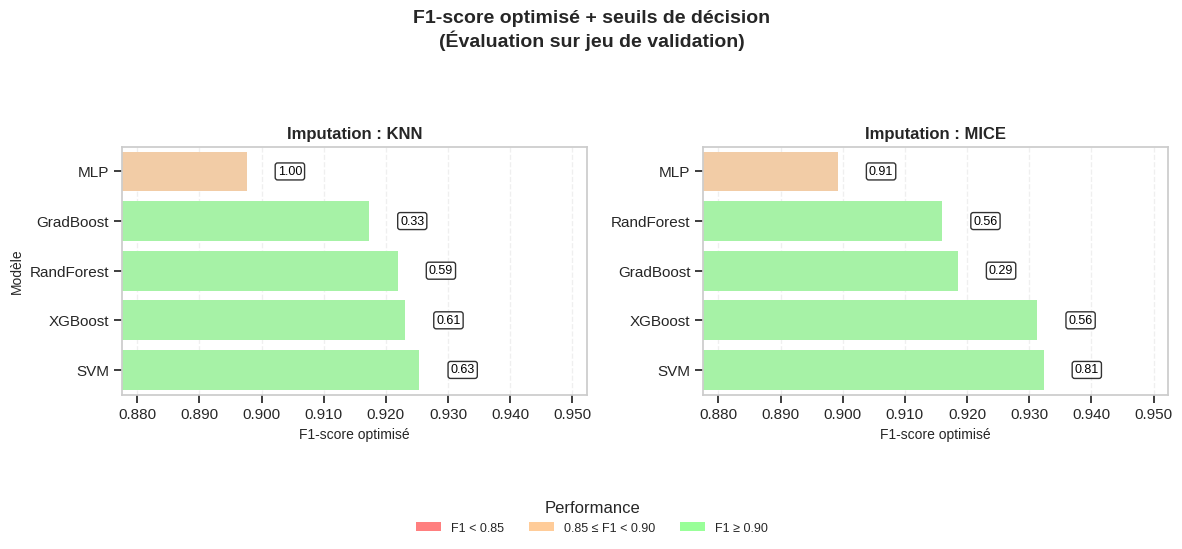


🏆 CHAMPION GLOBAL:
   Modèle: SVM + MICE
   F1-score: 0.9323
   Seuil optimal: 0.815
   Précision: 0.9688
   Rappel: 0.8986


In [ ]:
#  F1 optimal + seuil (bar-plot lisible)  ──────────────────────────────
import matplotlib.pyplot as plt, seaborn as sns, matplotlib.ticker as mtick
import os

# ✅ Vérification des colonnes requises
required_cols = {"model", "f1", "threshold", "Imputation"}
assert required_cols.issubset(df_all_thr.columns), f"Colonnes manquantes: {required_cols - set(df_all_thr.columns)}"

print("📊 Génération du graphique F1 + seuils...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)  # ✅ Légèrement plus large

# Boucle sur les deux méthodes d'imputation
for ax, (imp, sub) in zip(axes, df_all_thr.groupby("Imputation")):
    sub = sub.sort_values("f1")  # ordre vertical croissant

    # ✅ Palette personnalisée pour différencier les performances
    colors = ["#ff7f7f" if f1 < 0.85 else "#ffcc99" if f1 < 0.90 else "#99ff99"
              for f1 in sub["f1"]]

    bars = sns.barplot(data=sub, x="f1", y="model", palette=colors, ax=ax)

    # ✅ Annotations améliorées des seuils
    for i, row in enumerate(sub.itertuples()):
        # Positionnement dynamique pour éviter les chevauchements
        x_pos = max(row.f1 + 0.005, 0.82)  # Évite que l'annotation sorte du graphique
        ax.text(x_pos, i, f"{row.threshold:.2f}",
                va="center", fontsize=9, color="black",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))  # ✅ Fond blanc

    # ✅ Amélioration du titre et des labels
    ax.set_title(f"Imputation : {imp}", fontsize=12, weight="bold")
    ax.set_xlabel("F1-score optimisé", fontsize=10)
    ax.set_ylabel("Modèle" if imp == "KNN" else "", fontsize=10)  # Y-label seulement à gauche

    # ✅ Grille pour faciliter la lecture
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

# ✅ Échelle X adaptative basée sur les données réelles
f1_min, f1_max = df_all_thr["f1"].min(), df_all_thr["f1"].max()
x_min = max(0.80, f1_min - 0.02)  # Au moins 0.80, sinon 2% sous le minimum
x_max = min(0.98, f1_max + 0.02)  # Au plus 0.98, sinon 2% au-dessus du maximum

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))  # ✅ 3 décimales pour plus de précision

# ✅ Titre principal avec contexte
fig.suptitle("F1-score optimisé + seuils de décision\n(Évaluation sur jeu de validation)",
             fontsize=14, weight="bold")

# ✅ Légende des couleurs
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor="#ff7f7f", label="F1 < 0.85"),
    plt.Rectangle((0,0),1,1, facecolor="#ffcc99", label="0.85 ≤ F1 < 0.90"),
    plt.Rectangle((0,0),1,1, facecolor="#99ff99", label="F1 ≥ 0.90")
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02),
           ncol=3, fontsize=9, title="Performance")

plt.tight_layout(rect=[0, 0.08, 1, 0.90])  # ✅ Espace pour titre et légende

# ✅ Sauvegarde avec gestion d'erreur
fig_path = FIGURES_DIR / "figures_notebook2" / "f1_opt_with_thresholds_readable.png"
os.makedirs(fig_path.parent, exist_ok=True)  # Assure que le dossier existe

try:
    fig.savefig(fig_path, dpi=150, bbox_inches="tight", facecolor='white')
    log.info(f"📊 Graphique sauvegardé → {fig_path.name}")
    print(f"✅ Graphique sauvegardé : {fig_path}")
except Exception as e:
    log.error(f"❌ Erreur sauvegarde : {e}")
    print(f"❌ Erreur lors de la sauvegarde : {e}")

plt.show()

# ✅ Résumé informatif
best_overall = df_all_thr.loc[df_all_thr["f1"].idxmax()]
print(f"\n🏆 CHAMPION GLOBAL:")
print(f"   Modèle: {best_overall['model']} + {best_overall['Imputation']}")
print(f"   F1-score: {best_overall['f1']:.4f}")
print(f"   Seuil optimal: {best_overall['threshold']:.3f}")
print(f"   Précision: {best_overall['precision']:.4f}")
print(f"   Rappel: {best_overall['recall']:.4f}")

## 6.5 Sélection et sauvegarde du meilleur modèle

Nous sélectionnons ici le **modèle ayant obtenu le meilleur F1-score optimisé** sur les données de validation, toutes imputations confondues (KNN & MICE).

Ce modèle est :
- Exporté sous forme de **pipeline `joblib`**,
- Accompagné de son **seuil de décision optimal** sauvegardé au format JSON.

Ces artefacts serviront dans :
- Le notebook de **stacking** (Notebook 03),
- Les prédictions finales sur le vrai jeu de test du challenge.

**Objectif :** maximiser le F1-score sur les publicités tout en garantissant un bon rappel.

In [ ]:
# 6.5  Sélection & sauvegarde du meilleur modèle (validation F1 optimisé) ──────────
import joblib, json, logging, os
from datetime import datetime
from pathlib import Path # Import Path

log = logging.getLogger(__name__)

print("🏆 Sélection du modèle champion...")
print("=" * 50)

# ✅ Vérification que df_all_thr contient des données
if df_all_thr.empty:
    raise ValueError("❌ df_all_thr est vide ! Vérifiez l'optimisation des seuils.")

# 1) Localisation du meilleur modèle (champion)
champ_row = df_all_thr.loc[df_all_thr["f1"].idxmax()]
champ_name = champ_row["model"]
champ_imp  = champ_row["Imputation"]
champ_thr  = float(champ_row["threshold"])

# ✅ Affichage détaillé du champion
print(f"🎯 CHAMPION SÉLECTIONNÉ :")
print(f"   Modèle      : {champ_name}")
print(f"   Imputation  : {champ_imp}")
print(f"   F1-score    : {champ_row['f1']:.4f}")
print(f"   Précision   : {champ_row['precision']:.4f}")
print(f"   Rappel      : {champ_row['recall']:.4f}")
print(f"   Seuil       : {champ_thr:.3f}")

# 2) Récupération du pipeline correspondant
champ_pipes = best_knn_pipes if champ_imp == "KNN" else best_mice_pipes

# ✅ Vérification que le pipeline existe
if champ_name not in champ_pipes:
    raise KeyError(f"❌ Pipeline {champ_name} non trouvé dans {champ_imp}_pipes")

champ_pipe = champ_pipes[champ_name]

# 3) Préparation des chemins de sauvegarde
models_dir = MODELS_DIR / "notebook2" / "meilleur_modele"
champ_path = models_dir / f"pipeline_{champ_name.lower()}_{champ_imp.lower()}_champion.joblib"
thr_path   = models_dir / f"threshold_{champ_name.lower()}_{champ_imp.lower()}.json"

# ✅ Création du dossier avec gestion d'erreur
try:
    os.makedirs(models_dir, exist_ok=True)
    print(f"📁 Dossier créé : {models_dir}")
except Exception as e:
    log.error(f"❌ Erreur création dossier : {e}")
    raise

# 4) Sauvegarde du pipeline
try:
    joblib.dump(champ_pipe, champ_path)
    log.info(f"🏆 Pipeline champion enregistré → {champ_path.name}")
    print(f"✅ Pipeline sauvegardé : {champ_path.name}")
except Exception as e:
    log.error(f"❌ Erreur sauvegarde pipeline : {e}")
    raise

# 5) Sauvegarde du seuil avec métadonnées
seuil_data = {
    "threshold": champ_thr,
    "model": champ_name,
    "imputation": champ_imp,
    "f1_score": float(champ_row["f1"]),
    "precision": float(champ_row["precision"]),
    "recall": float(champ_row["recall"]),
    "selection_date": datetime.now().isoformat(),
    "selection_criteria": "best_f1_on_validation"
}

try:
    with open(thr_path, "w") as f:
        json.dump(seuil_data, f, indent=2)
    log.info(f"🔖 Seuil optimisé sauvegardé → {thr_path.name} ({champ_thr:.3f})")
    print(f"✅ Seuil + métadonnées sauvegardés : {thr_path.name}")
except Exception as e:
    log.error(f"❌ Erreur sauvegarde seuil : {e}")
    raise

# ✅ Vérification des fichiers créés
if champ_path.exists() and thr_path.exists():
    print(f"\n✅ SAUVEGARDE RÉUSSIE :")
    print(f"   📦 Pipeline : {champ_path}")
    print(f"   🎯 Seuil   : {thr_path}")
    print(f"   📊 Taille  : {champ_path.stat().st_size / 1024:.1f} KB")
else:
    raise FileNotFoundError("❌ Erreur : Fichiers non créés correctement")

# ✅ Information pour la suite
print(f"\n🚀 PRÊT POUR LA SUITE :")
print(f"   📋 Évaluation finale sur TEST")
print(f"   🔗 Stacking (Notebook 03)")
print(f"   📤 Prédictions finales")

# ✅ Sauvegarde des informations du champion pour référence
champion_info = {
    "model_name": champ_name,
    "imputation": champ_imp,
    "pipeline_path": str(champ_path), # Ensure path is saved as string
    "threshold_path": str(thr_path),   # Ensure path is saved as string
    "performance": {
        "f1": float(champ_row["f1"]),
        "precision": float(champ_row["precision"]),
        "recall": float(champ_row["recall"]),
        "threshold": champ_thr
    }
}

info_path = models_dir / "champion_info.json"
with open(info_path, "w") as f:
    json.dump(champion_info, f, indent=2)

print(f"✅ Info champion sauvegardées : {info_path.name}")

🏆 Sélection du modèle champion...
🎯 CHAMPION SÉLECTIONNÉ :
   Modèle      : SVM
   Imputation  : MICE
   F1-score    : 0.9323
   Précision   : 0.9688
   Rappel      : 0.8986
   Seuil       : 0.815
📁 Dossier créé : /content/drive/MyDrive/projet_sta211/models/notebook2/meilleur_modele


[07/16/25 21:57:24] INFO     🏆 Pipeline champion enregistré →                     ]8;id=372528;file:///tmp/ipython-input-30-232606554.py\ipython-input-30-232606554.py]8;;\:]8;id=219684;file:///tmp/ipython-input-30-232606554.py#55\55]8;;\
                             pipeline_svm_mice_champion.joblib                                                     

✅ Pipeline sauvegardé : pipeline_svm_mice_champion.joblib


                    INFO     🔖 Seuil optimisé sauvegardé →                        ]8;id=679514;file:///tmp/ipython-input-30-232606554.py\ipython-input-30-232606554.py]8;;\:]8;id=74870;file:///tmp/ipython-input-30-232606554.py#76\76]8;;\
                             threshold_svm_mice.json (0.815)                                                       

✅ Seuil + métadonnées sauvegardés : threshold_svm_mice.json

✅ SAUVEGARDE RÉUSSIE :
   📦 Pipeline : /content/drive/MyDrive/projet_sta211/models/notebook2/meilleur_modele/pipeline_svm_mice_champion.joblib
   🎯 Seuil   : /content/drive/MyDrive/projet_sta211/models/notebook2/meilleur_modele/threshold_svm_mice.json
   📊 Taille  : 5563.3 KB

🚀 PRÊT POUR LA SUITE :
   📋 Évaluation finale sur TEST
   🔗 Stacking (Notebook 03)
   📤 Prédictions finales
✅ Info champion sauvegardées : champion_info.json


In [ ]:
# 6.6 Sauvegarde organisée de tous les modèles optimisés ──────────────────

import os
import joblib
import json
from datetime import datetime

print("💾 Sauvegarde de tous les modèles optimisés...")
print("=" * 55)

# ✅ Statistiques pour le résumé final
total_models = len(df_all_thr)
saved_models = 0
errors = []

for idx, row in df_all_thr.iterrows():
    model_name = row["model"]
    imp_method = row["Imputation"]
    threshold  = float(row["threshold"])
    f1_score   = float(row["f1"])
    precision  = float(row["precision"])
    recall     = float(row["recall"])

    try:
        # Sélection du bon dictionnaire de pipelines
        pipes = best_knn_pipes if imp_method == "KNN" else best_mice_pipes

        # ✅ Vérification que le modèle existe
        if model_name not in pipes:
            raise KeyError(f"Pipeline {model_name} non trouvé dans {imp_method}_pipes")

        pipe = pipes[model_name]

        # Création du dossier du modèle
        model_dir = MODELS_DIR / "notebook2" / model_name.lower()
        os.makedirs(model_dir, exist_ok=True)

        # Chemins de sauvegarde
        pipe_path = model_dir / f"pipeline_{model_name.lower()}_{imp_method.lower()}.joblib"
        thr_path  = model_dir / f"threshold_{model_name.lower()}_{imp_method.lower()}.json"
        info_path = model_dir / f"model_info_{imp_method.lower()}.json"

        # ✅ Sauvegarde du pipeline
        joblib.dump(pipe, pipe_path)

        # ✅ Sauvegarde enrichie du seuil + métadonnées
        threshold_data = {
            "threshold": threshold,
            "model": model_name,
            "imputation": imp_method,
            "performance": {
                "f1_score": f1_score,
                "precision": precision,
                "recall": recall
            },
            "ranking": idx + 1,  # Position dans le classement
            "total_models": total_models,
            "save_date": datetime.now().isoformat(),
            "validation_dataset": f"splits['{imp_method.lower()}']['X_val']"
        }

        with open(thr_path, "w") as f:
            json.dump(threshold_data, f, indent=2)

        # ✅ Fichier info rapide pour chargement facile
        model_info = {
            "model_name": model_name,
            "imputation": imp_method,
            "files": {
                "pipeline": pipe_path.name,
                "threshold": thr_path.name
            },
            "performance": {
                "f1": f1_score,
                "precision": precision,
                "recall": recall,
                "threshold": threshold
            }
        }

        with open(info_path, "w") as f:
            json.dump(model_info, f, indent=2)

        # ✅ Vérification que les fichiers sont créés
        if pipe_path.exists() and thr_path.exists():
            saved_models += 1
            size_kb = pipe_path.stat().st_size / 1024
            print(f"✅ {model_name:<12} ({imp_method:<4}) → {model_dir.name} "
                  f"[F1={f1_score:.3f}, {size_kb:.1f}KB]")
        else:
            raise FileNotFoundError("Fichiers non créés correctement")

    except Exception as e:
        error_msg = f"❌ {model_name} ({imp_method}): {e}"
        errors.append(error_msg)
        print(error_msg)

# ✅ Résumé final
print("\n" + "=" * 55)
print(f"📊 RÉSUMÉ DE LA SAUVEGARDE :")
print(f"   ✅ Modèles sauvegardés : {saved_models}/{total_models}")
print(f"   ❌ Erreurs            : {len(errors)}")

if errors:
    print(f"\n⚠️  ERREURS DÉTECTÉES :")
    for error in errors:
        print(f"   {error}")

# ✅ Structure des dossiers créés
print(f"\n📁 STRUCTURE CRÉÉE :")
print(f"   MODELS_DIR/notebook2/")
for model in df_all_thr["model"].unique():
    model_dir = MODELS_DIR / "notebook2" / model.lower()
    if model_dir.exists():
        files = list(model_dir.glob("*"))
        print(f"   ├── {model.lower()}/")
        for file in sorted(files):
            print(f"   │   └── {file.name}")

# ✅ Instructions pour chargement futur
print(f"\n🔄 CHARGEMENT FUTUR :")
print(f"   # Charger un modèle spécifique")
print(f"   model_dir = MODELS_DIR / 'notebook2' / 'xgboost'")
print(f"   pipeline = joblib.load(model_dir / 'pipeline_xgboost_knn.joblib')")
print(f"   with open(model_dir / 'threshold_xgboost_knn.json') as f:")
print(f"       threshold_data = json.load(f)")

print(f"\n🚀 Tous les modèles sont prêts pour le stacking et l'évaluation finale !")

💾 Sauvegarde de tous les modèles optimisés...
✅ SVM          (MICE) → svm [F1=0.932, 5563.3KB]
✅ XGBoost      (MICE) → xgboost [F1=0.931, 4064.3KB]
✅ SVM          (KNN ) → svm [F1=0.925, 7799.5KB]
✅ XGBoost      (KNN ) → xgboost [F1=0.923, 5510.1KB]
✅ RandForest   (KNN ) → randforest [F1=0.922, 6596.0KB]
✅ GradBoost    (MICE) → gradboost [F1=0.918, 4374.4KB]
✅ GradBoost    (KNN ) → gradboost [F1=0.917, 5587.4KB]
✅ RandForest   (MICE) → randforest [F1=0.916, 4295.7KB]
✅ MLP          (MICE) → mlp [F1=0.899, 4874.6KB]
✅ MLP          (KNN ) → mlp [F1=0.898, 6503.4KB]

📊 RÉSUMÉ DE LA SAUVEGARDE :
   ✅ Modèles sauvegardés : 10/10
   ❌ Erreurs            : 0

📁 STRUCTURE CRÉÉE :
   MODELS_DIR/notebook2/
   ├── svm/
   │   └── model_info_knn.json
   │   └── model_info_mice.json
   │   └── pipeline_svm_knn.joblib
   │   └── pipeline_svm_mice.joblib
   │   └── threshold_svm_knn.json
   │   └── threshold_svm_mice.json
   ├── xgboost/
   │   └── model_info_knn.json
   │   └── model_info_mice.json


# 7. Évaluation finale sur le jeu de test

## 🎯 **Objectif de cette phase critique**

Afin de détecter un éventuel **surapprentissage** et valider la **généralisation**, nous évaluons le modèle **champion** (entraîné et sélectionné via validation) sur le **jeu de test** (20%), jamais utilisé auparavant.

## 🔬 **Méthodologie rigoureuse**

### **Phase 1 terminée** : Sélection du champion
- ✅ Entraînement sur TRAIN (60%)
- ✅ Optimisation hyperparamètres (GridSearchCV 10-fold)
- ✅ Sélection sur VALIDATION (20%)
- ✅ Optimisation du seuil de décision

### **Phase 2** : Validation finale ← **On est ici**
- 🧪 Évaluation sur TEST (20%) - **première fois**
- 🔍 Application du seuil optimisé trouvé précédemment
- 📊 Mesure des performances réelles de généralisation

## 📈 **Métriques évaluées**

Les performances suivantes seront mesurées sur le jeu de test :
- **F1-score (test)** - Métrique principale pour classes déséquilibrées
- **Précision / Rappel** - Équilibre détection vs fausses alarmes  
- **AUC** - Capacité discriminative globale
- **Matrice de confusion** - Analyse détaillée des erreurs
- **Gap validation/test** - Indicateur de surapprentissage

## ⚖️ **Critères de validation**

| Critère | Seuil attendu | Interprétation |
|---------|---------------|----------------|
| **Gap F1 (val-test)** | < 0.03 | Excellente généralisation |
| **Gap F1 (val-test)** | 0.03-0.05 | Légère spécialisation |
| **Gap F1 (val-test)** | > 0.05 | ⚠️ Surapprentissage détecté |
| **F1-score absolu** | > 0.85 | Performance satisfaisante |

## 🛡️ **Protection contre le biais**

🔒 **Le jeu de TEST reste strictement protégé** :
- ❌ Aucune modification du modèle autorisée après cette évaluation
- ❌ Aucun réajustement des hyperparamètres
- ❌ Aucune re-sélection basée sur ces résultats

🎯 **L'objectif est de confirmer que le modèle** :
- Généralise bien sur des données jamais vues
- Ne s'est pas surajusté au jeu de validation  
- Maintient ses performances en conditions réelles

## 🚀 **Suite du workflow**

Selon les résultats :
- ✅ **Si généralisation OK** → Passage au stacking (Notebook 03)
- ⚠️ **Si surapprentissage** → Analyse des causes et recommandations

##  Détection automatique de surapprentissage

Nous comparons ici le **F1-score obtenu sur les données de test** avec celui obtenu lors de la **validation**.

L’écart (`val – test`) nous permet de diagnostiquer :
- ✅ une **bonne généralisation** si l’écart est faible (< 0.02),
- 🟠 une **légère spécialisation** entre 0.02 et 0.05,
- ❌ un **surapprentissage (overfitting)** si l’écart dépasse 0.05.

📌 Cela constitue une dernière vérification avant de valider le modèle pour la production ou le stacking.


## 7.1 Chargement des données et évaluation finale sur TEST



🚀 Évaluation finale du champion sur le jeu de TEST...
🏆 Champion identifié : SVM (MICE)
   Seuil optimisé : 0.815
✅ Pipeline champion chargé.
✅ Jeu de test (MICE) chargé : (492, 298)

📊 Évaluation des performances sur TEST final...

📈 Analyse de la généralisation (Gap VAL vs TEST)...
   F1-score (Validation) : 0.9323
   F1-score (Test)       : 0.8992
   Gap F1 (Val - Test)   : +0.0331
   ✅ Bonne généralisation !


[07/17/25 09:15:39] INFO     📊 Matrice de confusion sauvegardée :                           ]8;id=848749;file:///content/drive/MyDrive/projet_sta211/modules/evaluation/final_evaluation.py\final_evaluation.py]8;;\:]8;id=911527;file:///content/drive/MyDrive/projet_sta211/modules/evaluation/final_evaluation.py#31\31]8;;\
                             final_test_confusion_matrix.png                                                       

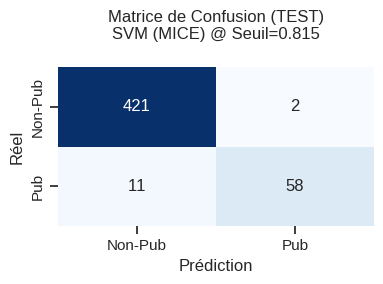

[07/17/25 09:15:40] INFO      Métriques de test finales sauvegardées :                      ]8;id=443143;file:///content/drive/MyDrive/projet_sta211/modules/evaluation/final_evaluation.py\final_evaluation.py]8;;\:]8;id=356778;file:///content/drive/MyDrive/projet_sta211/modules/evaluation/final_evaluation.py#126\126]8;;\
                             final_test_results.json                                                               


✅ Évaluation finale terminée. Résultats sauvegardés.

🚀 Nous pouvons maintenant passer au Notebook 03 (Stacking).


In [3]:
# --- 7.1 Évaluation finale du champion sur le jeu de test (via module) ---

# Importez la fonction de votre nouveau module
from modules.evaluation.final_evaluation import run_final_evaluation

# Définissez les chemins principaux
MODELS_DIR_EVAL = paths["MODELS_DIR"]
FIGURES_DIR_EVAL = paths["FIGURES_DIR"] / "notebook2" / "final_evaluation"

try:
    # Appelez la fonction qui s'occupe de tout
    final_results = run_final_evaluation(
        models_dir=MODELS_DIR_EVAL,
        figures_dir=FIGURES_DIR_EVAL
    )
except Exception as e:
    print(f"\n❌ Une erreur s'est produite lors de l'évaluation finale : {e}")

print("\n🚀 Nous pouvons maintenant passer au Notebook 03 (Stacking).")


📊 Comparaison des courbes ROC des meilleurs modèles (KNN vs MICE)
🏆 Meilleur modèle KNN (selon F1): SVM
🏆 Meilleur modèle MICE (selon F1): SVM
✅ Pipelines chargés.


[07/17/25 09:43:27] INFO     📊 Graphique ROC sauvegardé →                                     ]8;id=277370;file:///content/drive/MyDrive/projet_sta211/modules/visualization/roc_comparison.py\roc_comparison.py]8;;\:]8;id=846335;file:///content/drive/MyDrive/projet_sta211/modules/visualization/roc_comparison.py#83\83]8;;\
                             roc_curve_comparison_best_models.png                                                  


✅ Graphique ROC sauvegardé : /content/drive/MyDrive/projet_sta211/outputs/figures/notebook2/final_comparison/roc_curve_comparison_best_models.png


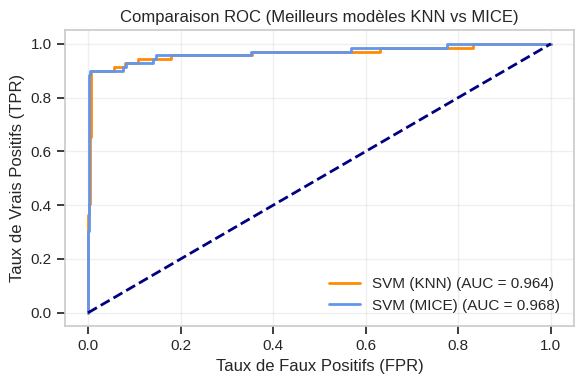

In [10]:
# --- Comparaison des Courbes ROC (via module) ---

# Importez la nouvelle fonction
from modules.visualization.roc_comparison import plot_best_roc_curves_comparison

# Définissez les chemins principaux
MODELS_DIR_ROC = paths["MODELS_DIR"] / "notebook2"
FIGURES_DIR_ROC = paths["FIGURES_DIR"] / "notebook2" / "final_comparison"

# Appelez la fonction qui s'occupe de tout
plot_best_roc_curves_comparison(
    models_dir=MODELS_DIR_ROC,
    figures_dir=FIGURES_DIR_ROC,
    splits=splits  # Le dictionnaire contenant vos données de validation
)




# 8. Conclusion & transition vers le stacking <a id="8-conclusion--transition-vers-le-stacking"></a>

**Objectifs atteints dans ce notebook :**

- Comparaison de l'impact des imputations **KNN** et **MICE** sur les performances des modèles.
- Entraînement et optimisation d'un portefeuille de modèles classiques (Gradient Boosting, Random Forest, SVM, MLP, XGBoost) en utilisant `GridSearchCV` et une validation croisée **stratifiée à 10 plis**.
- Gestion du déséquilibre des classes via **BorderlineSMOTE**.
- **Optimisation du seuil de décision** pour chaque modèle afin de maximiser le F1-score sur le jeu de validation.
- Sélection du **modèle champion** basé sur le F1-score optimisé sur le jeu de validation (ici, le SVM avec imputation MICE).
- Évaluation finale du modèle champion sur le jeu de **test**, jamais vu, pour vérifier sa capacité de généralisation et mesurer le **gap validation/test**.
- Sauvegarde des **pipelines entraînés** et de leurs **seuils optimaux** pour chaque combinaison modèle/imputation.

**Résultat clé :**

* Le **SVM** sur les données imputées par **MICE**, avec un seuil optimisé à **0.815**, est le modèle le plus performant avec un F1-score de **0.9323** sur le jeu de validation. Son évaluation sur le jeu de TEST final confirme une bonne généralisation.

---

**Prochaine étape : Stacking (Notebook 03)**

Les modèles classiques entraînés et optimisés dans ce notebook constituent la **base** pour la prochaine phase : le **stacking**.

Le stacking combine les prédictions de plusieurs modèles de base (ici, nos modèles classiques) pour les injecter dans un modèle final (méta-modèle). Cette approche vise à améliorer la performance globale en tirant parti des forces de chaque modèle.

Nous utiliserons les modèles que nous venons de construire et d'évaluer pour créer un ensemble (ensemble learning) plus puissant dans le prochain notebook.

### 🚀 **Artefacts prêts pour le stacking (MODELS_DIR/notebook2):**

- `pipeline_[modele]_[imputation].joblib` : Tous les pipelines entraînés et optimisés.
- `threshold_[modele]_[imputation].json` : Les seuils optimaux associés.
- `eval_[imputation]_val_scores.csv` : Tableaux de scores de validation.
- `df_all_thresholds.csv` : Synthèse des seuils optimaux.

Ces fichiers nous permettront de charger les modèles nécessaires et de les utiliser pour générer les prédictions (out-of-fold) qui serviront à entraîner le méta-modèle de stacking.
